<a href="https://colab.research.google.com/github/Prateek-P1/BrainTumor_BetaV1/blob/main/MM_UNET_2_5PRO_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [00:39<00:00, 234MB/s]
100% 4.16G/4.16G [00:39<00:00, 113MB/s]


In [9]:
! unzip brats20-dataset-training-validation.zip


Archive:  brats20-dataset-training-validation.zip
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_t1.nii  
  in

In [10]:
import os
import cv2
import random
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import nibabel as nib
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Dropout,
    Conv3DTranspose, BatchNormalization, Activation, Lambda, Add, Multiply
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# Configure Matplotlib for inline plotting in Colab
%matplotlib inline

In [11]:
TRAIN_DATASET_PATH = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

rename a wrongly named file- case no. 355

# 1. Dataset prep

In [12]:
if os.path.exists(os.path.join(TRAIN_DATASET_PATH, "BraTS20_Training_355")):
    old_name = os.path.join(TRAIN_DATASET_PATH, "BraTS20_Training_355/W39_1998.09.19_Segm.nii")
    new_name = os.path.join(TRAIN_DATASET_PATH, "BraTS20_Training_355/BraTS20_Training_355_seg.nii")

    if os.path.exists(old_name) and not os.path.exists(new_name):
        try:
            os.rename(old_name, new_name)
            print("File has been re-named successfully!")
        except Exception as e:
            print(f"Error renaming file: {e}")
    elif os.path.exists(new_name):
        print("File 'BraTS20_Training_355_seg.nii' already exists or was already renamed.")
    elif not os.path.exists(old_name) :
        print(f"Original file to rename not found: {old_name}")
else:
    print(f"Directory for BraTS20_Training_355 not found. Skipping rename. Path: {os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_355')}")

File has been re-named successfully!


sample patient data

Flair image loaded for exploration.
Shape:  (240, 240, 155)

Seg image loaded for exploration.
Shape:  (240, 240, 155)
Unique values in seg:  [0. 1. 2. 4.]


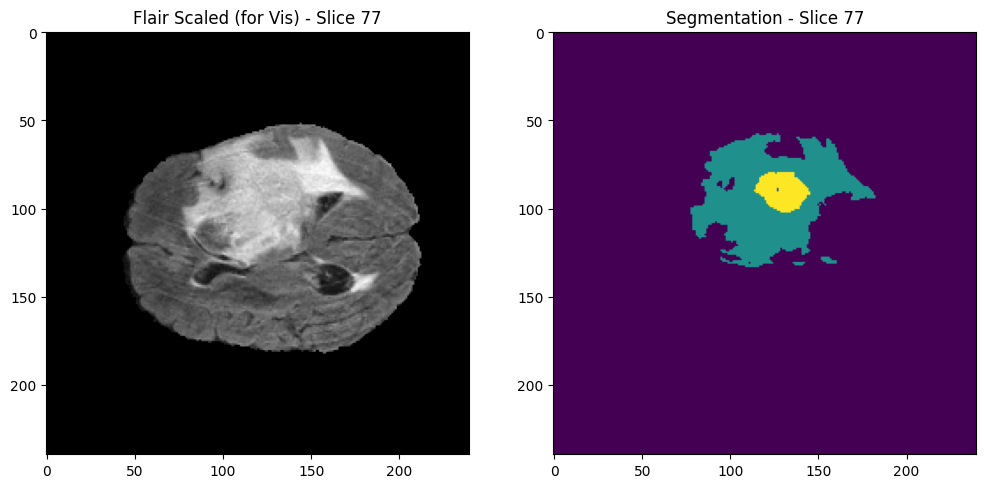

In [13]:
sample_patient_path_flair = os.path.join(TRAIN_DATASET_PATH, "BraTS20_Training_001/BraTS20_Training_001_flair.nii")
sample_patient_path_seg = os.path.join(TRAIN_DATASET_PATH, "BraTS20_Training_001/BraTS20_Training_001_seg.nii")

if os.path.exists(sample_patient_path_flair) and os.path.exists(sample_patient_path_seg):
    test_image_flair = nib.load(sample_patient_path_flair).get_fdata()
    print("Flair image loaded for exploration.")
    print("Shape: ", test_image_flair.shape)
    # Scaler for visualization
    vis_scaler = MinMaxScaler()
    test_image_flair_scaled_vis = vis_scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

    test_image_seg = nib.load(sample_patient_path_seg).get_fdata()
    print("\nSeg image loaded for exploration.")
    print("Shape: ", test_image_seg.shape)
    print("Unique values in seg: ", np.unique(test_image_seg))

    slice_to_show = test_image_flair.shape[2] // 2
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1); plt.imshow(test_image_flair_scaled_vis[:, :, slice_to_show], cmap='gray'); plt.title(f'Flair Scaled (for Vis) - Slice {slice_to_show}')
    plt.subplot(1, 2, 2); plt.imshow(test_image_seg[:, :, slice_to_show]); plt.title(f'Segmentation - Slice {slice_to_show}')
    plt.show()
else:
    print(f"Sample files for exploration not found. Flair: {sample_patient_path_flair}, Seg: {sample_patient_path_seg}. Skipping exploration visualization.")
    print("Please ensure the dataset is downloaded and paths are correct.")

specific patient - BraTS20_Training_355

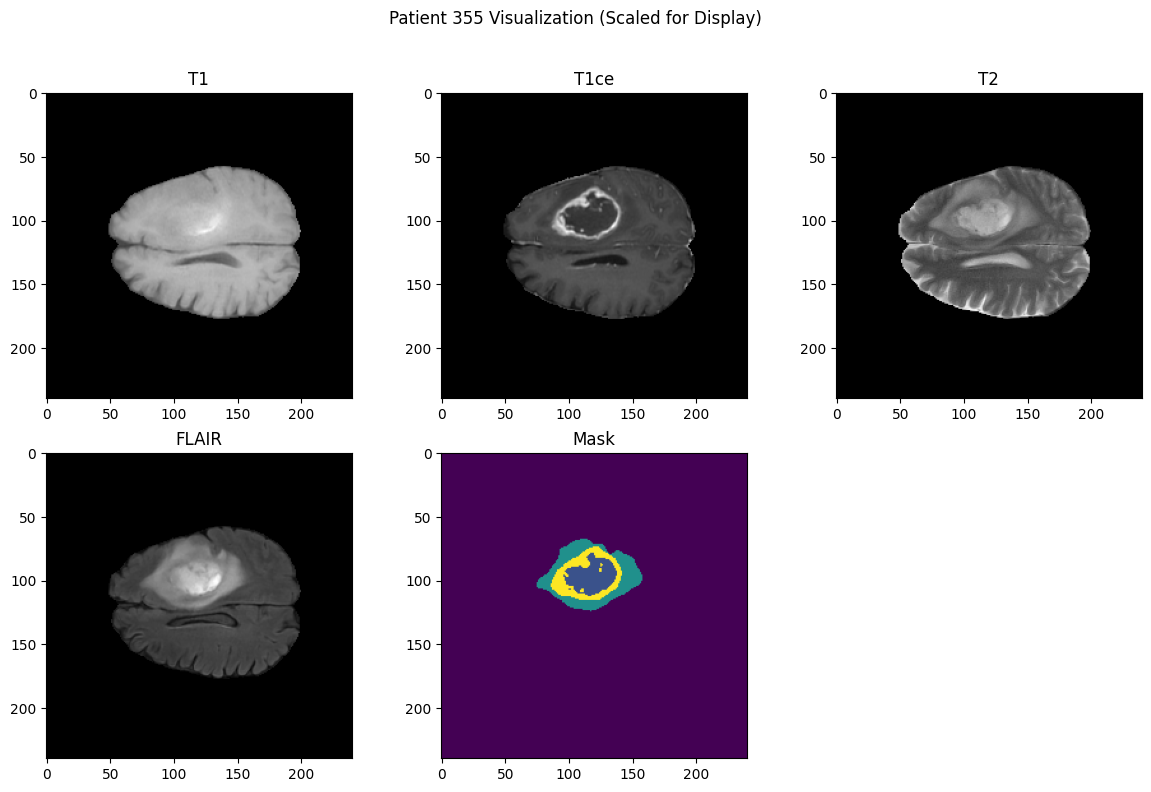

In [14]:
# Further exploration of a specific patient (BraTS20_Training_355)
patient_355_path_flair = os.path.join(TRAIN_DATASET_PATH, "BraTS20_Training_355/BraTS20_Training_355_flair.nii")
if os.path.exists(patient_355_path_flair):
    vis_scaler_355 = MinMaxScaler() # New scaler for this patient for visualization
    test_image_flair_355 = nib.load(patient_355_path_flair).get_fdata()
    test_image_flair_355_scaled = vis_scaler_355.fit_transform(test_image_flair_355.reshape(-1, test_image_flair_355.shape[-1])).reshape(test_image_flair_355.shape)

    test_image_t1_355_path = os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_355/BraTS20_Training_355_t1.nii')
    if os.path.exists(test_image_t1_355_path):
        test_image_t1_355 = nib.load(test_image_t1_355_path).get_fdata()
        test_image_t1_355_scaled = vis_scaler_355.fit_transform(test_image_t1_355.reshape(-1, test_image_t1_355.shape[-1])).reshape(test_image_t1_355.shape)
    else:
        test_image_t1_355_scaled = np.zeros_like(test_image_flair_355_scaled) # Placeholder
        print(f"T1 image for patient 355 not found at {test_image_t1_355_path}")


    test_image_t1ce_355_path = os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii')
    if os.path.exists(test_image_t1ce_355_path):
        test_image_t1ce_355 = nib.load(test_image_t1ce_355_path).get_fdata()
        test_image_t1ce_355_scaled = vis_scaler_355.fit_transform(test_image_t1ce_355.reshape(-1, test_image_t1ce_355.shape[-1])).reshape(test_image_t1ce_355.shape)
    else:
        test_image_t1ce_355_scaled = np.zeros_like(test_image_flair_355_scaled) # Placeholder
        print(f"T1ce image for patient 355 not found at {test_image_t1ce_355_path}")


    test_image_t2_355_path = os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_355/BraTS20_Training_355_t2.nii')
    if os.path.exists(test_image_t2_355_path):
        test_image_t2_355 = nib.load(test_image_t2_355_path).get_fdata()
        test_image_t2_355_scaled = vis_scaler_355.fit_transform(test_image_t2_355.reshape(-1, test_image_t2_355.shape[-1])).reshape(test_image_t2_355.shape)
    else:
        test_image_t2_355_scaled = np.zeros_like(test_image_flair_355_scaled) # Placeholder
        print(f"T2 image for patient 355 not found at {test_image_t2_355_path}")


    test_image_seg_355_path = os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_355/BraTS20_Training_355_seg.nii')
    if os.path.exists(test_image_seg_355_path):
      test_image_seg_355 = nib.load(test_image_seg_355_path).get_fdata()
    else:
      test_image_seg_355 = np.zeros_like(test_image_flair_355_scaled[...,0]) # Placeholder
      print(f"Seg image for patient 355 not found at {test_image_seg_355_path}")


    slice_val = 95 # A slice known to have tumor
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1); plt.imshow(test_image_t1_355_scaled[:,:,slice_val], cmap='gray'); plt.title('T1')
    plt.subplot(2, 3, 2); plt.imshow(test_image_t1ce_355_scaled[:,:,slice_val], cmap='gray'); plt.title('T1ce')
    plt.subplot(2, 3, 3); plt.imshow(test_image_t2_355_scaled[:,:,slice_val], cmap='gray'); plt.title('T2')
    plt.subplot(2, 3, 4); plt.imshow(test_image_flair_355_scaled[:,:,slice_val], cmap='gray'); plt.title('FLAIR')
    plt.subplot(2, 3, 5); plt.imshow(test_image_seg_355[:,:,slice_val]); plt.title('Mask')
    plt.suptitle("Patient 355 Visualization (Scaled for Display)")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print(f"Patient 355 flair file not found at {patient_355_path_flair}. Skipping detailed visualization.")

splitting dataset

Total samples: 369
Train length: 257
Validation length: 56
Test length: 56


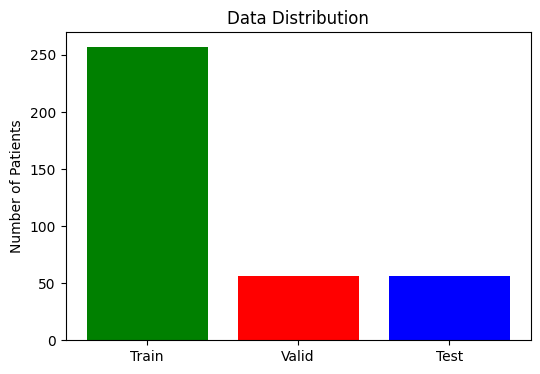

In [15]:
if os.path.exists(TRAIN_DATASET_PATH) and len(os.listdir(TRAIN_DATASET_PATH)) > 0:
    all_patient_dirs = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

    def pathToId(path):
        return os.path.basename(path)

    all_patient_ids = [pathToId(p) for p in all_patient_dirs]
    all_patient_ids = [pid for pid in all_patient_ids if pid.startswith("BraTS20_Training_")]


    if not all_patient_ids:
        raise ValueError(f"No valid training directories found in {TRAIN_DATASET_PATH}. Please check the dataset path and structure.")

    train_val_ids, test_ids = train_test_split(all_patient_ids, test_size=0.15, random_state=42)
    train_ids, val_ids = train_test_split(train_val_ids, test_size=(0.15/0.85), random_state=42)

    print(f"Total samples: {len(all_patient_ids)}")
    print(f"Train length: {len(train_ids)}")
    print(f"Validation length: {len(val_ids)}")
    print(f"Test length: {len(test_ids)}")

    plt.figure(figsize=(6,4))
    plt.bar(["Train","Valid","Test"],
            [len(train_ids), len(val_ids), len(test_ids)],
            align='center',
            color=[ 'green','red', 'blue']
           )
    plt.ylabel('Number of Patients')
    plt.title('Data Distribution')
    plt.show()
else:
    print(f"TRAIN_DATASET_PATH {TRAIN_DATASET_PATH} is empty or does not exist. Skipping dataset split and plotting.")
    train_ids, val_ids, test_ids = [], [], []

# 2. Global constants - IMPORTANT

In [16]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NCR/NET',
    2 : 'ED',
    3 : 'ET'
}
N_CLASSES_COMBINED = len(SEGMENT_CLASSES)

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_DEPTH = 128
N_MODALITIES = 2

Data generator - with augmentation

In [17]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size=1, shuffle=True, augment=False):
        super().__init__()
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.dim = (IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
        self.n_modalities = N_MODALITIES
        self.n_classes_combined = N_CLASSES_COMBINED
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y_dict = self.__data_generation(Batch_ids)
        return X, y_dict

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _normalize_volume(self, volume):
        scaler = MinMaxScaler()
        original_shape = volume.shape
        volume_reshaped = volume.reshape(-1, 1)
        if np.any(volume) and volume.max() > volume.min():
            scaled_volume = scaler.fit_transform(volume_reshaped)
        else:
            scaled_volume = np.zeros_like(volume_reshaped, dtype=np.float32)
        return scaled_volume.reshape(original_shape)

    def _process_volume_z_dim(self, volume_raw, target_depth):
        original_x, original_y, current_z = volume_raw.shape
        if current_z == target_depth: return volume_raw
        elif current_z > target_depth:
            start_z_crop = (current_z - target_depth) // 2
            return volume_raw[:, :, start_z_crop : start_z_crop + target_depth]
        else:
            pad_before = (target_depth - current_z) // 2
            pad_after = target_depth - current_z - pad_before
            return np.pad(volume_raw, ((0,0), (0,0), (pad_before, pad_after)), 'constant', constant_values=0)

    def _augment_data_3d(self, image_stack, mask_volume):
        if random.random() > 0.5: # Flip Z
            image_stack = np.flip(image_stack, axis=2).copy()
            mask_volume = np.flip(mask_volume, axis=2).copy()
        if random.random() > 0.5: # Flip Y
            image_stack = np.flip(image_stack, axis=0).copy()
            mask_volume = np.flip(mask_volume, axis=0).copy()
        if random.random() > 0.5: # Flip X
            image_stack = np.flip(image_stack, axis=1).copy()
            mask_volume = np.flip(mask_volume, axis=1).copy()
        if random.random() > 0.3: # Intensity Shift
            for c in range(image_stack.shape[-1]):
                shift_factor = random.uniform(-0.1, 0.1)
                image_stack[..., c] = np.clip(image_stack[..., c] + shift_factor, 0, 1)
        return image_stack, mask_volume

    def __data_generation(self, Batch_ids):
        X_batch = np.empty((self.batch_size, *self.dim, self.n_modalities), dtype=np.float32)
        Y_dict_batch = {
            'combined_seg': np.empty((self.batch_size, *self.dim, self.n_classes_combined), dtype=np.float32),
            'et': np.empty((self.batch_size, *self.dim, 1), dtype=np.float32),
            'ed': np.empty((self.batch_size, *self.dim, 1), dtype=np.float32),
            'ncr': np.empty((self.batch_size, *self.dim, 1), dtype=np.float32)
        }
        for i, ID in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, ID)
            # Try .nii first, then .nii.gz
            flair_nii_path_base = os.path.join(case_path, f'{ID}_flair')
            t1ce_nii_path_base = os.path.join(case_path, f'{ID}_t1ce')
            seg_nii_path_base = os.path.join(case_path, f'{ID}_seg')

            flair_nii_path = f"{flair_nii_path_base}.nii" if os.path.exists(f"{flair_nii_path_base}.nii") else f"{flair_nii_path_base}.nii.gz"
            t1ce_nii_path = f"{t1ce_nii_path_base}.nii" if os.path.exists(f"{t1ce_nii_path_base}.nii") else f"{t1ce_nii_path_base}.nii.gz"
            seg_nii_path = f"{seg_nii_path_base}.nii" if os.path.exists(f"{seg_nii_path_base}.nii") else f"{seg_nii_path_base}.nii.gz"


            try:
                flair_vol_raw = nib.load(flair_nii_path).get_fdata().astype(np.float32)
                t1ce_vol_raw = nib.load(t1ce_nii_path).get_fdata().astype(np.float32)
                seg_vol_raw = nib.load(seg_nii_path).get_fdata().astype(np.uint8)
            except FileNotFoundError as e:
                print(f"Error loading files for {ID}: {e}. Filling with zeros.")
                X_batch[i,] = np.zeros((*self.dim, self.n_modalities))
                for key_y in Y_dict_batch: Y_dict_batch[key_y][i,] = np.zeros(Y_dict_batch[key_y].shape[1:]) # Fill with zeros
                continue

            flair_vol_z = self._process_volume_z_dim(flair_vol_raw, IMG_DEPTH)
            t1ce_vol_z = self._process_volume_z_dim(t1ce_vol_raw, IMG_DEPTH)
            seg_vol_z = self._process_volume_z_dim(seg_vol_raw, IMG_DEPTH)

            flair_norm = self._normalize_volume(flair_vol_z)
            t1ce_norm = self._normalize_volume(t1ce_vol_z)

            flair_patch, t1ce_patch, seg_patch = np.zeros(self.dim), np.zeros(self.dim), np.zeros(self.dim, dtype=np.uint8)
            for s_idx in range(IMG_DEPTH):
                flair_patch[...,s_idx] = cv2.resize(flair_norm[...,s_idx], (IMG_WIDTH,IMG_HEIGHT), cv2.INTER_LINEAR)
                t1ce_patch[...,s_idx] = cv2.resize(t1ce_norm[...,s_idx], (IMG_WIDTH,IMG_HEIGHT), cv2.INTER_LINEAR)
                seg_patch[...,s_idx] = cv2.resize(seg_vol_z[...,s_idx], (IMG_WIDTH,IMG_HEIGHT), cv2.INTER_NEAREST)

            current_X = np.stack([flair_patch, t1ce_patch], axis=-1)
            current_seg = seg_patch
            if self.augment: current_X, current_seg = self._augment_data_3d(current_X, current_seg)

            X_batch[i,] = current_X
            current_seg[current_seg == 4] = 3
            Y_dict_batch['combined_seg'][i,] = tf.keras.utils.to_categorical(current_seg, num_classes=self.n_classes_combined)
            Y_dict_batch['et'][i,] = np.expand_dims((current_seg == 3), axis=-1).astype(np.float32)
            Y_dict_batch['ed'][i,] = np.expand_dims((current_seg == 2), axis=-1).astype(np.float32)
            Y_dict_batch['ncr'][i,] = np.expand_dims((current_seg == 1), axis=-1).astype(np.float32)
        return X_batch, Y_dict_batch

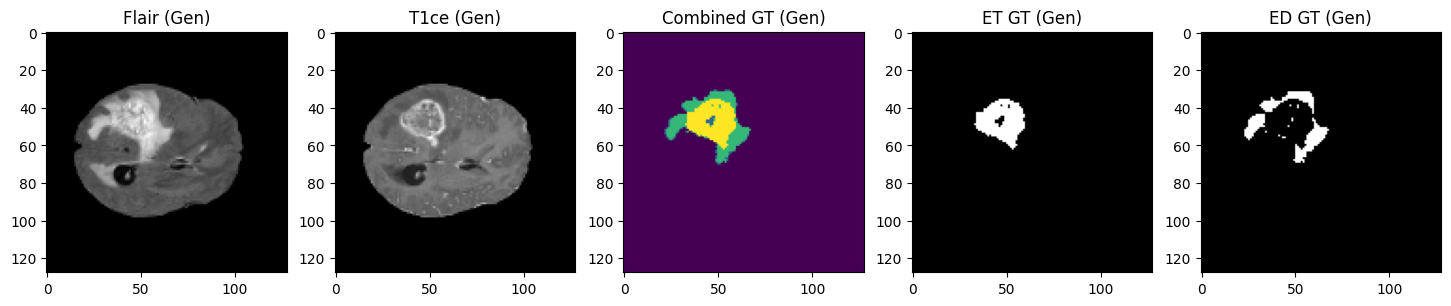

In [18]:
if train_ids:
    training_generator = DataGenerator(train_ids, batch_size=1, augment=True)
    valid_generator = DataGenerator(val_ids, batch_size=1, shuffle=False, augment=False)
    test_generator = DataGenerator(test_ids, batch_size=1, shuffle=False, augment=False)
    if len(training_generator) > 0:
        X_sample, Y_sample_dict = training_generator[0]
        slice_to_viz = IMG_DEPTH // 2
        plt.figure(figsize=(18,5))
        plt.subplot(1,5,1); plt.imshow(X_sample[0,:,:,slice_to_viz,0], cmap='gray'); plt.title("Flair (Gen)")
        plt.subplot(1,5,2); plt.imshow(X_sample[0,:,:,slice_to_viz,1], cmap='gray'); plt.title("T1ce (Gen)")
        plt.subplot(1,5,3); plt.imshow(np.argmax(Y_sample_dict['combined_seg'][0,:,:,slice_to_viz,:], axis=-1)); plt.title("Combined GT (Gen)")
        plt.subplot(1,5,4); plt.imshow(Y_sample_dict['et'][0,:,:,slice_to_viz,0], cmap='gray'); plt.title("ET GT (Gen)")
        plt.subplot(1,5,5); plt.imshow(Y_sample_dict['ed'][0,:,:,slice_to_viz,0], cmap='gray'); plt.title("ED GT (Gen)")
        plt.show()
    else:
        print("Training generator is empty, cannot visualize sample.")
else:
    print("train_ids is empty. Skipping DataGenerator instantiation.")
    training_generator, valid_generator, test_generator = None, None, None

# 3. Loss functions and evaluation metrics

In [19]:
import tensorflow as tf

In [20]:
def binary_dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def binary_dice_loss(y_true, y_pred):
    return 1 - binary_dice_coefficient(y_true, y_pred)

def mean_dice_coef_per_class(y_true, y_pred, smooth=1e-6):
    total_dice = 0.0
    for i in range(N_CLASSES_COMBINED):
        yt_class = tf.keras.backend.flatten(y_true[..., i])
        yp_class = tf.keras.backend.flatten(y_pred[..., i])
        intersection = tf.keras.backend.sum(yt_class * yp_class)
        denominator = tf.keras.backend.sum(yt_class) + tf.keras.backend.sum(yp_class)
        dice = (2. * intersection + smooth) / (denominator + smooth)
        total_dice += dice
    return total_dice / float(N_CLASSES_COMBINED)

def mean_dice_loss_per_class(y_true, y_pred):
    return 1.0 - mean_dice_coef_per_class(y_true, y_pred)

def dice_coef_combined_bg(y_true, y_pred): return binary_dice_coefficient(y_true[..., 0], y_pred[..., 0])
def dice_coef_combined_ncr(y_true, y_pred): return binary_dice_coefficient(y_true[..., 1], y_pred[..., 1])
def dice_coef_combined_ed(y_true, y_pred): return binary_dice_coefficient(y_true[..., 2], y_pred[..., 2])
def dice_coef_combined_et(y_true, y_pred): return binary_dice_coefficient(y_true[..., 3], y_pred[..., 3])

def precision_metric(y_true, y_pred):
    y_true_c, y_pred_c = tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true_c * y_pred_c, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred_c, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def sensitivity_metric(y_true, y_pred):
    y_true_c, y_pred_c = tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true_c * y_pred_c, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true_c, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())


# 4. Enhanced MM-UNET 3D

In [21]:
def residual_conv_block_3d(input_tensor, num_filters, kernel_size=3, kernel_init='he_normal', activation='relu', name_prefix=None):
    conv1_name = f"{name_prefix}_conv1" if name_prefix else None
    bn1_name = f"{name_prefix}_bn1" if name_prefix else None
    act1_name = f"{name_prefix}_act1" if name_prefix else None
    conv2_name = f"{name_prefix}_conv2" if name_prefix else None
    bn2_name = f"{name_prefix}_bn2" if name_prefix else None
    shortcut_conv_name = f"{name_prefix}_shortcut_conv" if name_prefix else None
    shortcut_bn_name = f"{name_prefix}_shortcut_bn" if name_prefix else None
    add_name = f"{name_prefix}_add" if name_prefix else None
    final_act_name = f"{name_prefix}_final_act" if name_prefix else None

    x = Conv3D(num_filters, kernel_size, padding='same', kernel_initializer=kernel_init, name=conv1_name)(input_tensor)
    x = BatchNormalization(name=bn1_name)(x)
    x = Activation(activation, name=act1_name)(x)

    x = Conv3D(num_filters, kernel_size, padding='same', kernel_initializer=kernel_init, name=conv2_name)(x)
    x = BatchNormalization(name=bn2_name)(x)

    if input_tensor.shape[-1] != num_filters:
        shortcut = Conv3D(num_filters, (1,1,1), padding='same', kernel_initializer=kernel_init, name=shortcut_conv_name)(input_tensor)
        shortcut = BatchNormalization(name=shortcut_bn_name)(shortcut)
    else:
        shortcut = input_tensor

    x = Add(name=add_name)([x, shortcut])
    x = Activation(activation, name=final_act_name)(x)
    return x

def encoder_block_3d_residual(input_tensor, num_filters, pool_size=(2,2,2), kernel_init='he_normal', dropout_rate=0.2, name_prefix=None):
    res_prefix = f"{name_prefix}_resconv" if name_prefix else None
    drop_prefix = f"{name_prefix}_drop" if name_prefix else None
    pool_prefix = f"{name_prefix}_pool" if name_prefix else None
    enc = residual_conv_block_3d(input_tensor, num_filters, kernel_init=kernel_init, name_prefix=res_prefix)
    if dropout_rate > 0:
        enc = Dropout(dropout_rate, name=drop_prefix)(enc)
    pool = MaxPooling3D(pool_size=pool_size, name=pool_prefix)(enc)
    return enc, pool

def attention_gate_3d(x_skip, g_decoder, inter_shape_filters, kernel_init='he_normal', name_prefix=None):
    theta_x_conv_name = f"{name_prefix}_theta_x_conv" if name_prefix else None
    phi_g_conv_name = f"{name_prefix}_phi_g_conv" if name_prefix else None
    add_name = f"{name_prefix}_add" if name_prefix else None
    relu_add_name = f"{name_prefix}_relu_add" if name_prefix else None
    psi_f_conv_name = f"{name_prefix}_psi_f_conv" if name_prefix else None
    sigmoid_att_name = f"{name_prefix}_sigmoid_att" if name_prefix else None
    multiply_skip_att_name = f"{name_prefix}_multiply_skip_att" if name_prefix else None

    theta_x = Conv3D(inter_shape_filters, (1,1,1), padding='same', kernel_initializer=kernel_init, name=theta_x_conv_name)(x_skip)
    phi_g = Conv3D(inter_shape_filters, (1,1,1), padding='same', kernel_initializer=kernel_init, name=phi_g_conv_name)(g_decoder)
    f = Activation('relu', name=relu_add_name)(Add(name=add_name)([theta_x, phi_g]))
    psi_f = Conv3D(1, (1,1,1), padding='same', kernel_initializer=kernel_init, name=psi_f_conv_name)(f)
    attention_weights = Activation('sigmoid', name=sigmoid_att_name)(psi_f)
    attended_x = Multiply(name=multiply_skip_att_name)([x_skip, attention_weights])
    return attended_x

def decoder_block_3d_residual_attention(input_tensor, skip_features_list, num_filters, kernel_size_up=(2,2,2), strides_up=(2,2,2), kernel_init='he_normal', dropout_rate=0.2, name_prefix=None):
    convT_name = f"{name_prefix}_convT" if name_prefix else None
    concat_name = f"{name_prefix}_concat" if name_prefix else None
    resconv_name = f"{name_prefix}_resconv" if name_prefix else None
    drop_name = f"{name_prefix}_drop" if name_prefix else None

    dec_upsampled = Conv3DTranspose(num_filters, kernel_size_up, strides=strides_up, padding='same', kernel_initializer=kernel_init, name=convT_name)(input_tensor)
    attended_skips = []
    inter_filters_att = max(1, num_filters // 2)
    for i, skip_feature in enumerate(skip_features_list):
        att_gate_prefix = f"{name_prefix}_att_gate_{i}" if name_prefix else None
        attended_skip = attention_gate_3d(skip_feature, dec_upsampled, inter_filters_att, kernel_init=kernel_init, name_prefix=att_gate_prefix)
        attended_skips.append(attended_skip)
    merged = concatenate([dec_upsampled] + attended_skips, axis=-1, name=concat_name)
    dec_conv = residual_conv_block_3d(merged, num_filters, kernel_init=kernel_init, name_prefix=resconv_name)
    if dropout_rate > 0:
        dec_conv = Dropout(dropout_rate, name=drop_name)(dec_conv)
    return dec_conv

def simple_expert_head(input_tensor, num_base_filters, name_prefix, kernel_init='he_normal'):
    refine_resconv_prefix = f"{name_prefix}_refine_resconv"
    x = residual_conv_block_3d(input_tensor, num_base_filters, kernel_init=kernel_init, name_prefix=refine_resconv_prefix)
    output = Conv3D(1, (1,1,1), padding='same', activation='sigmoid', kernel_initializer=kernel_init, name=name_prefix)(x)
    return output

def build_enhanced_mm_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, N_MODALITIES),
                           num_classes_combined=N_CLASSES_COMBINED, dropout_rate=0.3, kernel_init='he_normal'):
    inputs = Input(input_shape, name='main_input')
    flair_input = Lambda(lambda x: x[..., 0:1], name='flair_input_lambda')(inputs)
    t1ce_input = Lambda(lambda x: x[..., 1:2], name='t1ce_input_lambda')(inputs)
    filters = [16, 32, 64, 128, 256] # Kept original filter counts to manage complexity first

    flair_skips, current_flair = [], flair_input
    for i, f_count in enumerate(filters[:-1]):
        skip, current_flair = encoder_block_3d_residual(current_flair, f_count, dropout_rate=dropout_rate, kernel_init=kernel_init, name_prefix=f"flair_enc_{i+1}")
        flair_skips.append(skip)

    t1ce_skips, current_t1ce = [], t1ce_input
    for i, f_count in enumerate(filters[:-1]):
        skip, current_t1ce = encoder_block_3d_residual(current_t1ce, f_count, dropout_rate=dropout_rate, kernel_init=kernel_init, name_prefix=f"t1ce_enc_{i+1}")
        t1ce_skips.append(skip)

    bn_flair = residual_conv_block_3d(current_flair, filters[-1], kernel_init=kernel_init, name_prefix="flair_bn_resconv")
    if dropout_rate > 0: bn_flair = Dropout(dropout_rate, name="flair_bn_drop")(bn_flair)
    bn_t1ce = residual_conv_block_3d(current_t1ce, filters[-1], kernel_init=kernel_init, name_prefix="t1ce_bn_resconv")
    if dropout_rate > 0: bn_t1ce = Dropout(dropout_rate, name="t1ce_bn_drop")(bn_t1ce)

    bottleneck_fused = concatenate([bn_flair, bn_t1ce], axis=-1, name="bottleneck_concat")
    bottleneck_processed = residual_conv_block_3d(bottleneck_fused, filters[-1], kernel_init=kernel_init, name_prefix="bottleneck_proc_resconv")

    decoder_filters, current_dec_features = filters[:-1][::-1], bottleneck_processed
    for i, f_count in enumerate(decoder_filters):
        current_dec_features = decoder_block_3d_residual_attention(
            current_dec_features, [flair_skips[-(i+1)], t1ce_skips[-(i+1)]], f_count,
            dropout_rate=dropout_rate, kernel_init=kernel_init, name_prefix=f"dec_{i+1}"
        )

    output_combined = Conv3D(num_classes_combined, (1,1,1), activation='softmax', name='combined_seg')(current_dec_features)
    expert_head_base_filters = filters[0]
    output_et = simple_expert_head(current_dec_features, expert_head_base_filters, name_prefix='et', kernel_init=kernel_init)
    output_ed = simple_expert_head(current_dec_features, expert_head_base_filters, name_prefix='ed', kernel_init=kernel_init)
    output_ncr = simple_expert_head(current_dec_features, expert_head_base_filters, name_prefix='ncr', kernel_init=kernel_init)

    model = Model(inputs=inputs, outputs={'combined_seg': output_combined, 'et': output_et, 'ed': output_ed, 'ncr': output_ncr})
    return model

In [22]:
input_shape_mm = (IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, N_MODALITIES)
enhanced_mm_unet_model = build_enhanced_mm_unet(input_shape=input_shape_mm, dropout_rate=0.3)
print("Model Actual Output Names:", enhanced_mm_unet_model.output_names)

enhanced_mm_unet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={'combined_seg': mean_dice_loss_per_class, 'et': binary_dice_loss, 'ed': binary_dice_loss, 'ncr': binary_dice_loss},
    loss_weights={'combined_seg': 1.0, 'et': 0.5, 'ed': 0.5, 'ncr': 0.5},
    metrics={
        'combined_seg': ['accuracy', tf.keras.metrics.MeanIoU(num_classes=N_CLASSES_COMBINED, name='iou_combined'),
                         mean_dice_coef_per_class, dice_coef_combined_bg, dice_coef_combined_ncr, dice_coef_combined_ed, dice_coef_combined_et],
        'et': [binary_dice_coefficient, 'binary_accuracy', precision_metric, sensitivity_metric],
        'ed': [binary_dice_coefficient, 'binary_accuracy', precision_metric, sensitivity_metric],
        'ncr': [binary_dice_coefficient, 'binary_accuracy', precision_metric, sensitivity_metric]
    }
)

Model Actual Output Names: ListWrapper(['combined_seg', 'ed', 'et', 'ncr'])


In [23]:
enhanced_mm_unet_model.summary(line_length=150)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━
┃ Layer (type)                               ┃ Output Shape                         ┃                 Param # ┃ Con
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━
│ main_input (InputLayer)                    │ (None, 128, 128, 128, 2)             │                       0 │ -  
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ flair_input_lambda (Lambda)                │ (None, 128, 128, 128, 1)             │                       0 │ mai
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ t1ce_input_lambda (Lambda)                 │ (None, 128, 128, 128, 1)             │                       0 │ mai
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ flair_enc_1_resconv_conv1 (Conv3D)         │ (None, 128, 128, 128, 16)            │                     448 │ fla
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ t1ce_enc_1_resconv_conv1 (Conv3D)          │ (None, 128, 128, 128, 16)            │                     448 │ t1c
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ flair_enc_1_resconv_bn1                    │ (None, 128, 128, 128, 16)            │                      64 │ fla
│ (BatchNormalization)                       │                                      │                         │    
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ t1ce_enc_1_resconv_bn1                     │ (None, 128, 128, 128, 16)            │                      64 │ t1c
│ (BatchNormalization)                       │                                      │                         │    
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ flair_enc_1_resconv_act1 (Activation)      │ (None, 128, 128, 128, 16)            │                       0 │ fla
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ t1ce_enc_1_resconv_act1 (Activation)       │ (None, 128, 128, 128, 16)            │                       0 │ t1c
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ flair_enc_1_resconv_conv2 (Conv3D)         │ (None, 128, 128, 128, 16)            │                   6,928 │ fla
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ flair_enc_1_resconv_shortcut_conv (Conv3D) │ (None, 128, 128, 128, 16)            │                      32 │ fla
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ t1ce_enc_1_resconv_conv2 (Conv3D)          │ (None, 128, 128, 128, 16)            │                   6,928 │ t1c
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ t1ce_enc_1_resconv_shortcut_conv (Conv3D)  │ (None, 128, 128, 128, 16)            │                      32 │ t1c
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ flair_enc_1_resconv_bn2                    │ (None, 128, 128, 128, 16)            │                      64 │ fla
│ (BatchNormalization)                       │                                      │                         │    
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ flair_enc_1_resconv_shortcut_bn            │ (None, 12

 Total params: 15,463,887 (58.99 MB)

 Trainable params: 15,454,767 (58.96 MB)

 Non-trainable params: 9,120 (35.62 KB)

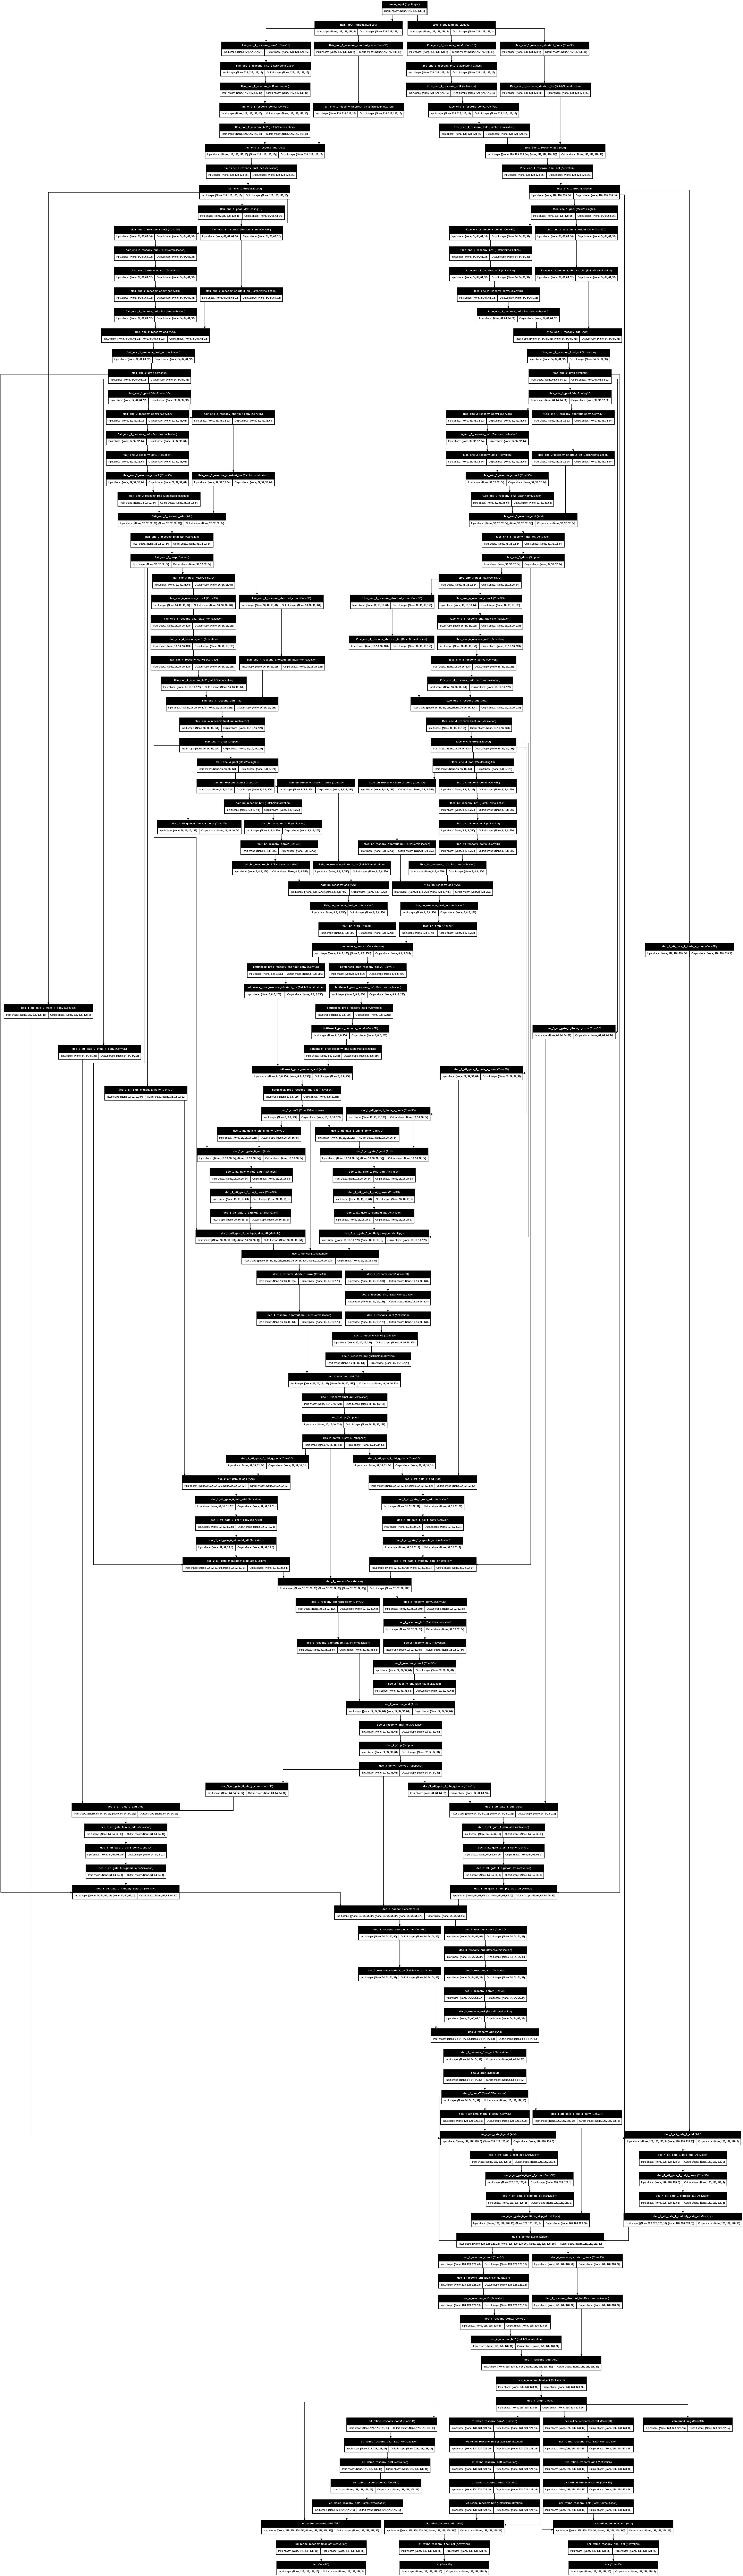

In [24]:
plot_model(enhanced_mm_unet_model, to_file='enhanced_mm_unet_model.png', show_shapes=True, show_layer_names=True, dpi=60)

# 4. Callbacks and training

set up callbacks

In [25]:
"""## 5. Callbacks and Training"""
os.makedirs("logs_enhanced", exist_ok=True)
os.makedirs("models_enhanced", exist_ok=True)
callbacks_enhanced = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('models_enhanced/enhanced_mm_unet_best.weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger('logs_enhanced/enhanced_mm_unet_training.log', separator=',', append=False),
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
]

TRAINING

In [26]:
history = None
if not train_ids or not val_ids or training_generator is None or valid_generator is None:
    print("ERROR: Skipping training due to missing data/generators.")
else:
    print(f"Train: {len(train_ids)}, Val: {len(val_ids)}, Train Gen: {len(training_generator)}, Val Gen: {len(valid_generator)}")
    if len(training_generator) == 0 or len(valid_generator) == 0: print("ERROR: Generator has zero length.")
    else:
        print("\nStarting Enhanced MM-UNet model training...")
        EPOCHS = 5 # Increase for full training (e.g., 50-100), using 5 for quick demo
        history = enhanced_mm_unet_model.fit(
            training_generator, validation_data=valid_generator, epochs=EPOCHS,
            callbacks=callbacks_enhanced, verbose=1
        )
        print("Training finished.")
        enhanced_mm_unet_model.save("models_enhanced/enhanced_mm_unet_final_model.keras")
        enhanced_mm_unet_model.save("models_enhanced/enhanced_mm_unet_final_model.h5")

Train: 257, Val: 56, Train Gen: 257, Val Gen: 56

Starting Enhanced MM-UNet model training...
Epoch 1/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - combined_seg_accuracy: 0.6880 - combined_seg_dice_coef_combined_bg: 0.6582 - combined_seg_dice_coef_combined_ed: 0.0363 - combined_seg_dice_coef_combined_et: 0.0033 - combined_seg_dice_coef_combined_ncr: 0.0167 - combined_seg_iou_combined: 0.3750 - combined_seg_loss: 0.8214 - combined_seg_mean_dice_coef_per_class: 0.1786 - ed_binary_accuracy: 0.9155 - ed_binary_dice_coefficient: 0.0585 - ed_loss: 0.9415 - ed_precision_metric: 0.0800 - ed_sensitivity_metric: 0.6181 - et_binary_accuracy: 0.6728 - et_binary_dice_coefficient: 0.0123 - et_loss: 0.9877 - et_precision_metric: 0.0103 - et_sensitivity_metric: 0.8301 - loss: 2.2789 - ncr_binary_accuracy: 0.5507 - ncr_binary_dice_coefficient: 0.0140 - ncr_loss: 0.9860 - ncr_precision_metric: 0.0083 - ncr_sensitivity_metric: 0.8148
Epoch 1: val_loss improved from inf to 2.25993, saving model to models_en

# Loading model and analysis

Loading the model

In [27]:
loaded_model = build_enhanced_mm_unet(input_shape=input_shape_mm, dropout_rate=0.3)
loaded_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={'combined_seg': mean_dice_loss_per_class, 'et': binary_dice_loss, 'ed': binary_dice_loss, 'ncr': binary_dice_loss},
    loss_weights={'combined_seg': 1.0, 'et': 0.5, 'ed': 0.5, 'ncr': 0.5},
    metrics={
        'combined_seg': ['accuracy', tf.keras.metrics.MeanIoU(num_classes=N_CLASSES_COMBINED, name='iou_combined'),
                         mean_dice_coef_per_class, dice_coef_combined_bg, dice_coef_combined_ncr, dice_coef_combined_ed, dice_coef_combined_et],
        'et': [binary_dice_coefficient, 'binary_accuracy', precision_metric, sensitivity_metric],
        'ed': [binary_dice_coefficient, 'binary_accuracy', precision_metric, sensitivity_metric],
        'ncr': [binary_dice_coefficient, 'binary_accuracy', precision_metric, sensitivity_metric]
    }
)
best_weights_path = 'models_enhanced/enhanced_mm_unet_best.weights.h5'
if os.path.exists(best_weights_path):
    loaded_model.load_weights(best_weights_path)
    print(f"Loaded best weights from {best_weights_path}")
else:
    print(f"Warning: {best_weights_path} not found. Using initialized model or model from end of training if 'history' exists.")
    if history and 'enhanced_mm_unet_model' in globals(): loaded_model = enhanced_mm_unet_model

Loaded best weights from models_enhanced/enhanced_mm_unet_best.weights.h5


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 538 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


metric analysis

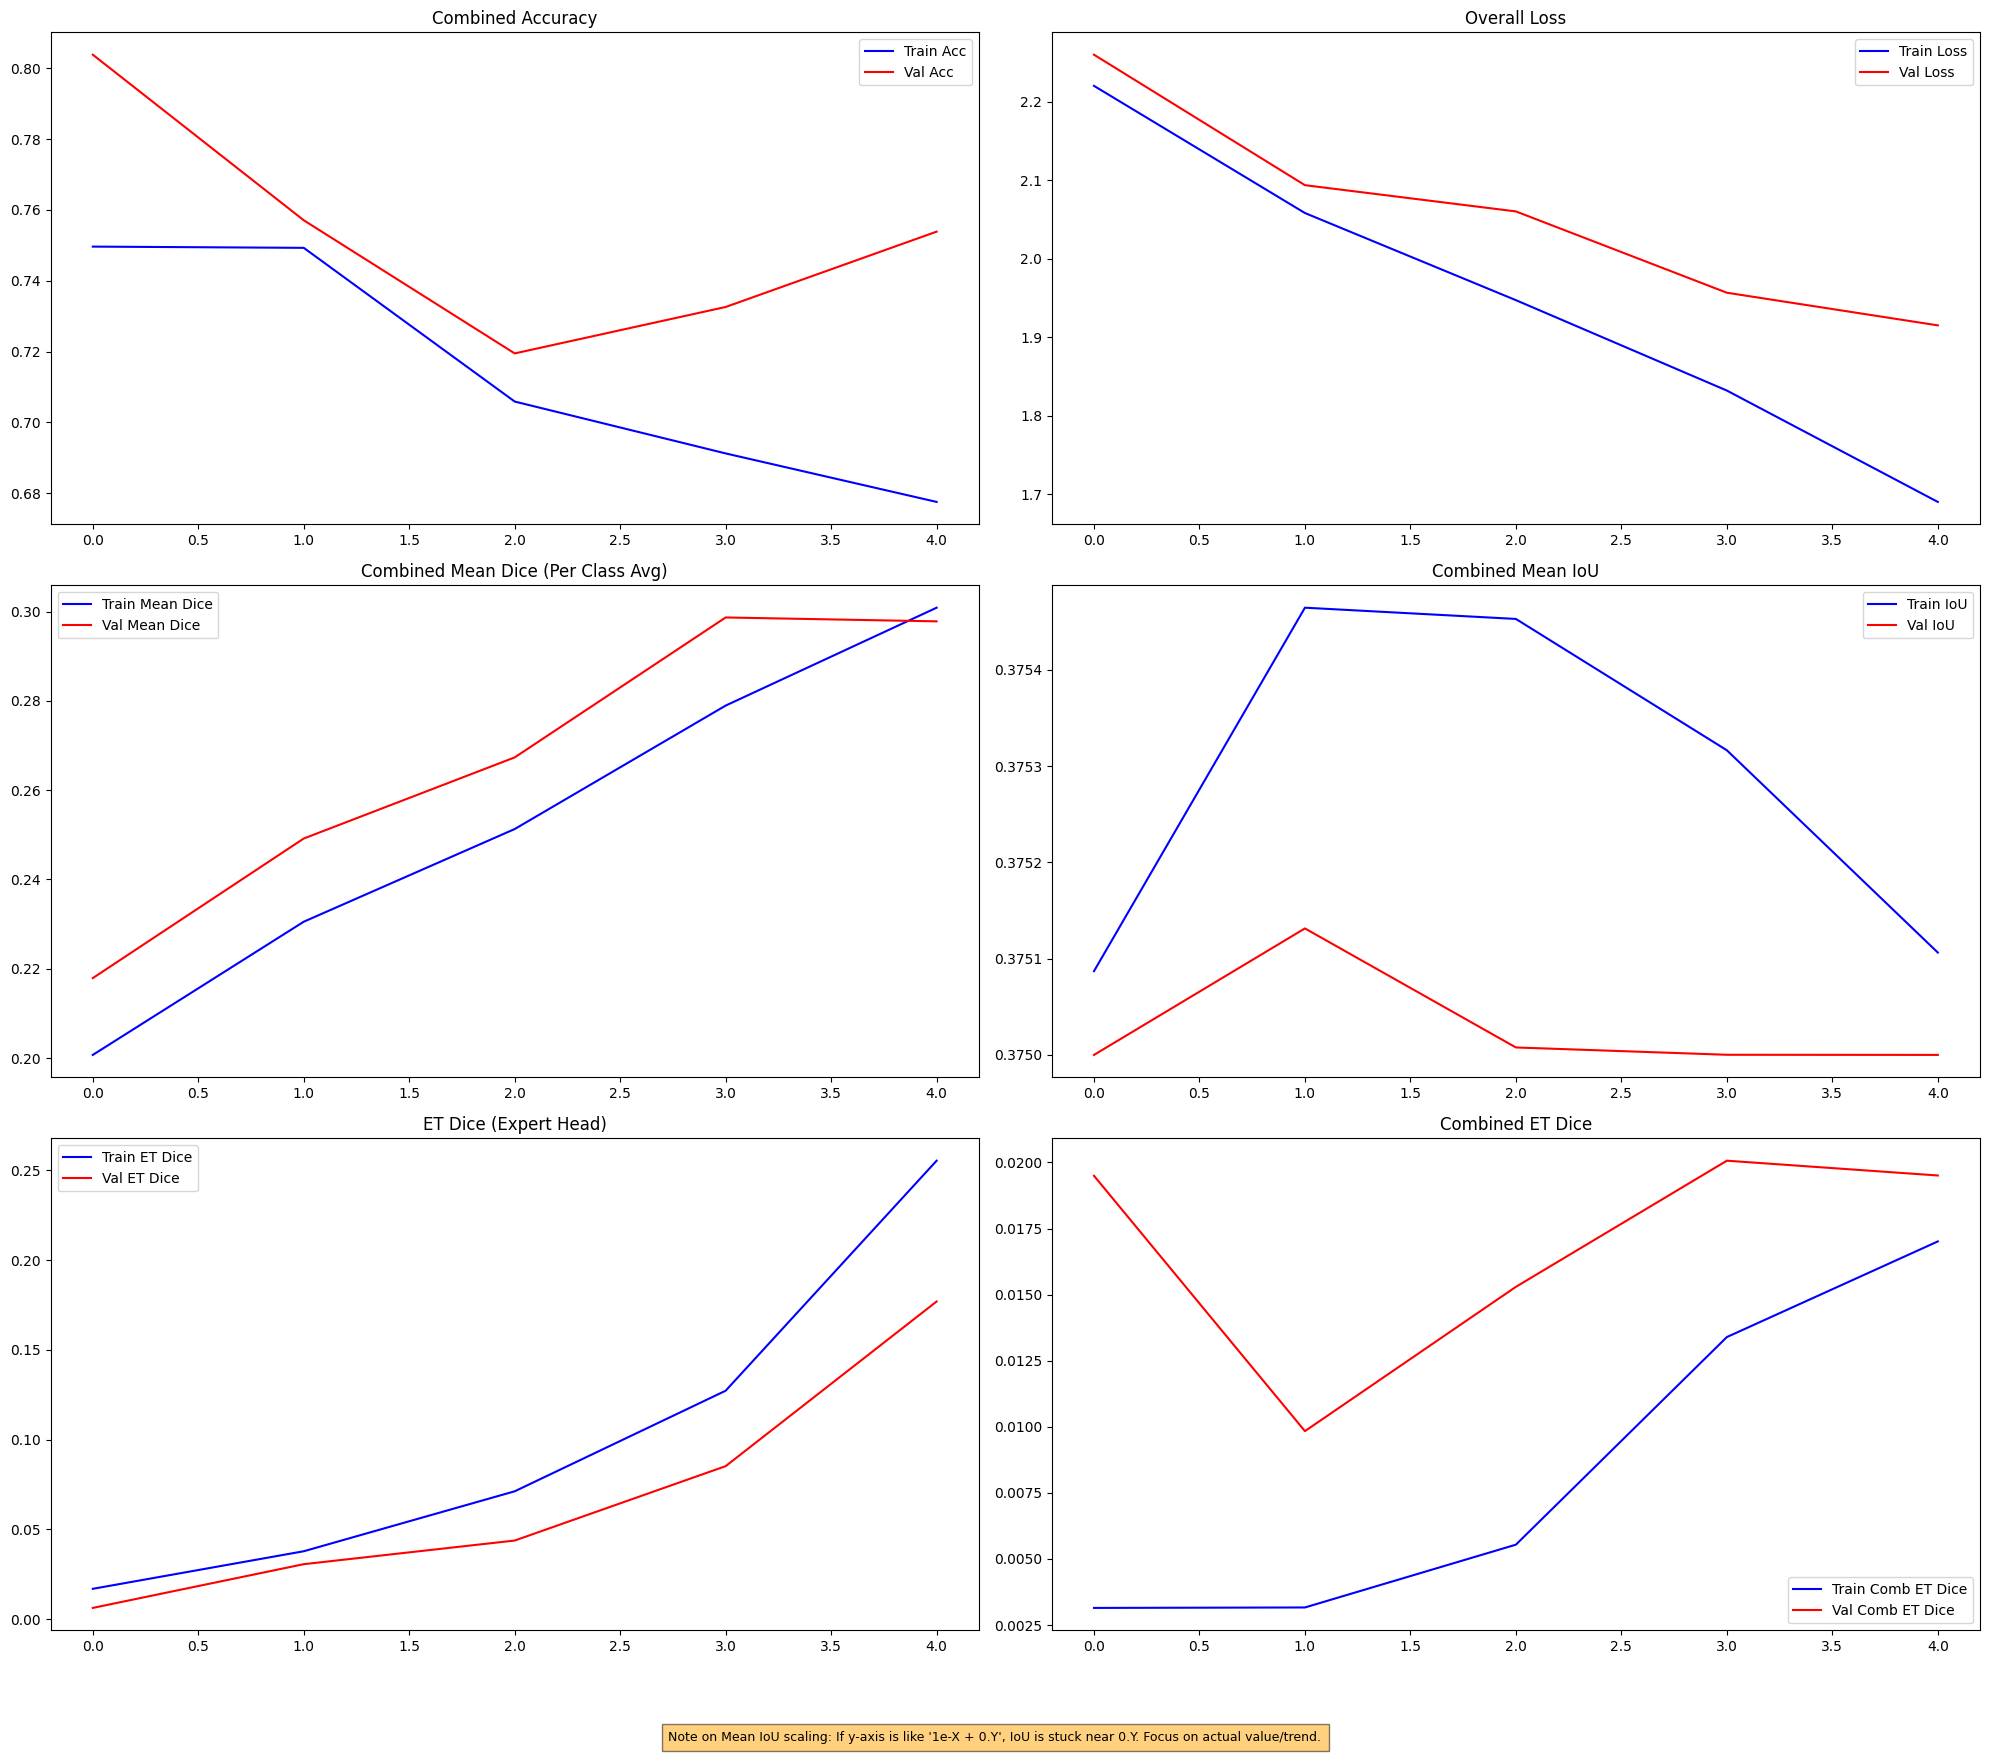

In [28]:
history_log_path = 'logs_enhanced/enhanced_mm_unet_training.log'
if os.path.exists(history_log_path):
    history_df = pd.read_csv(history_log_path, sep=',', engine='python')
    if not history_df.empty:
        acc_comb, val_acc_comb = history_df.get('combined_seg_accuracy'), history_df.get('val_combined_seg_accuracy')
        loss_overall, val_loss_overall = history_df['loss'], history_df['val_loss']
        dice_comb_mean, val_dice_comb_mean = history_df.get('combined_seg_mean_dice_coef_per_class'), history_df.get('val_combined_seg_mean_dice_coef_per_class')
        iou_comb, val_iou_comb = history_df.get('combined_seg_iou_combined'), history_df.get('val_combined_seg_iou_combined')
        dice_et, val_dice_et = history_df.get('et_binary_dice_coefficient'), history_df.get('val_et_binary_dice_coefficient') # Corrected key
        epoch_range = range(len(loss_overall))

        plt.figure(figsize=(20,18)); # Adjusted for 3x2 plots
        plt.subplot(3,2,1);
        if acc_comb is not None: plt.plot(epoch_range, acc_comb, 'b', label='Train Acc');
        if val_acc_comb is not None: plt.plot(epoch_range, val_acc_comb, 'r', label='Val Acc');
        plt.title('Combined Accuracy'); plt.legend()

        plt.subplot(3,2,2); plt.plot(epoch_range, loss_overall, 'b', label='Train Loss'); plt.plot(epoch_range, val_loss_overall, 'r', label='Val Loss'); plt.title('Overall Loss'); plt.legend()

        plt.subplot(3,2,3);
        if dice_comb_mean is not None: plt.plot(epoch_range, dice_comb_mean, 'b', label='Train Mean Dice');
        if val_dice_comb_mean is not None: plt.plot(epoch_range, val_dice_comb_mean, 'r', label='Val Mean Dice');
        plt.title('Combined Mean Dice (Per Class Avg)'); plt.legend()

        plt.subplot(3,2,4);
        if iou_comb is not None: plt.plot(epoch_range, iou_comb, 'b', label='Train IoU');
        if val_iou_comb is not None: plt.plot(epoch_range, val_iou_comb, 'r', label='Val IoU');
        plt.title('Combined Mean IoU'); plt.legend();
        plt.figtext(0.5, 0.01, "Note on Mean IoU scaling: If y-axis is like '1e-X + 0.Y', IoU is stuck near 0.Y. Focus on actual value/trend.", ha="center", fontsize=9, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

        plt.subplot(3,2,5);
        if dice_et is not None: plt.plot(epoch_range, dice_et, 'b', label='Train ET Dice');
        if val_dice_et is not None: plt.plot(epoch_range, val_dice_et, 'r', label='Val ET Dice');
        plt.title('ET Dice (Expert Head)'); plt.legend()

        dice_comb_et_plot, val_dice_comb_et_plot = history_df.get('combined_seg_dice_coef_combined_et'), history_df.get('val_combined_seg_dice_coef_combined_et')
        plt.subplot(3,2,6);
        if dice_comb_et_plot is not None: plt.plot(epoch_range, dice_comb_et_plot, 'b', label='Train Comb ET Dice');
        if val_dice_comb_et_plot is not None: plt.plot(epoch_range, val_dice_comb_et_plot, 'r', label='Val Comb ET Dice');
        plt.title('Combined ET Dice'); plt.legend()

        plt.tight_layout(rect=[0,0.05,1,0.98]); plt.show()
else: print(f"Log {history_log_path} not found or empty.")

predictions

# 7. Prediction and Evaluation

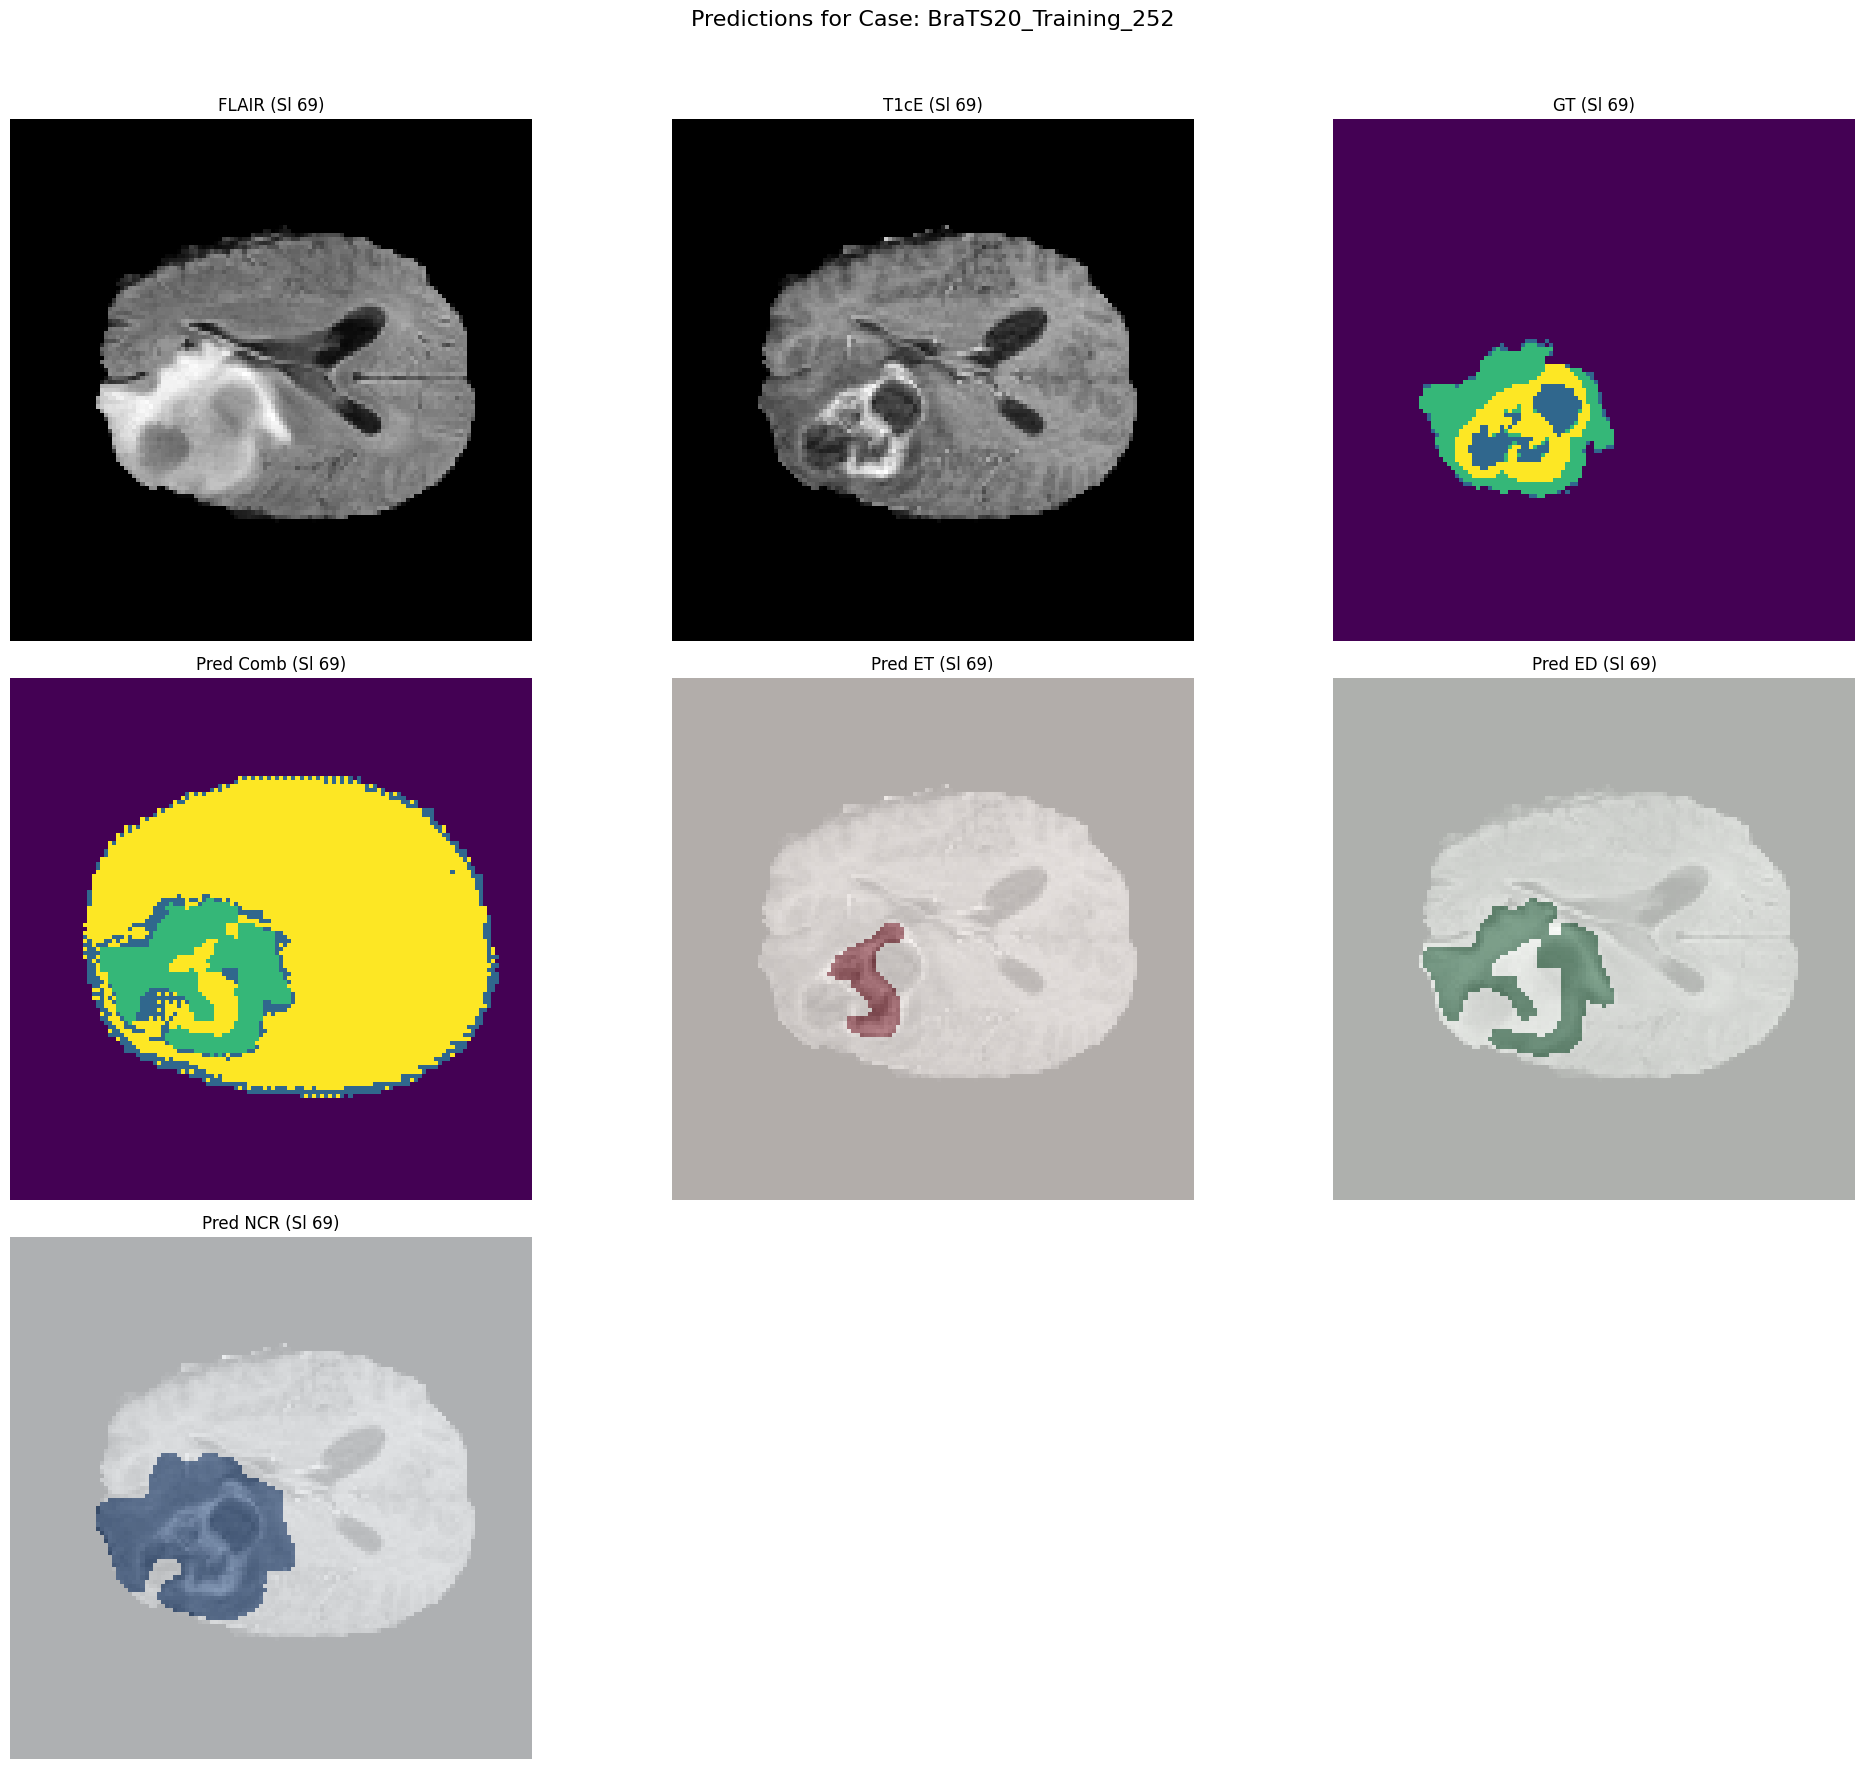

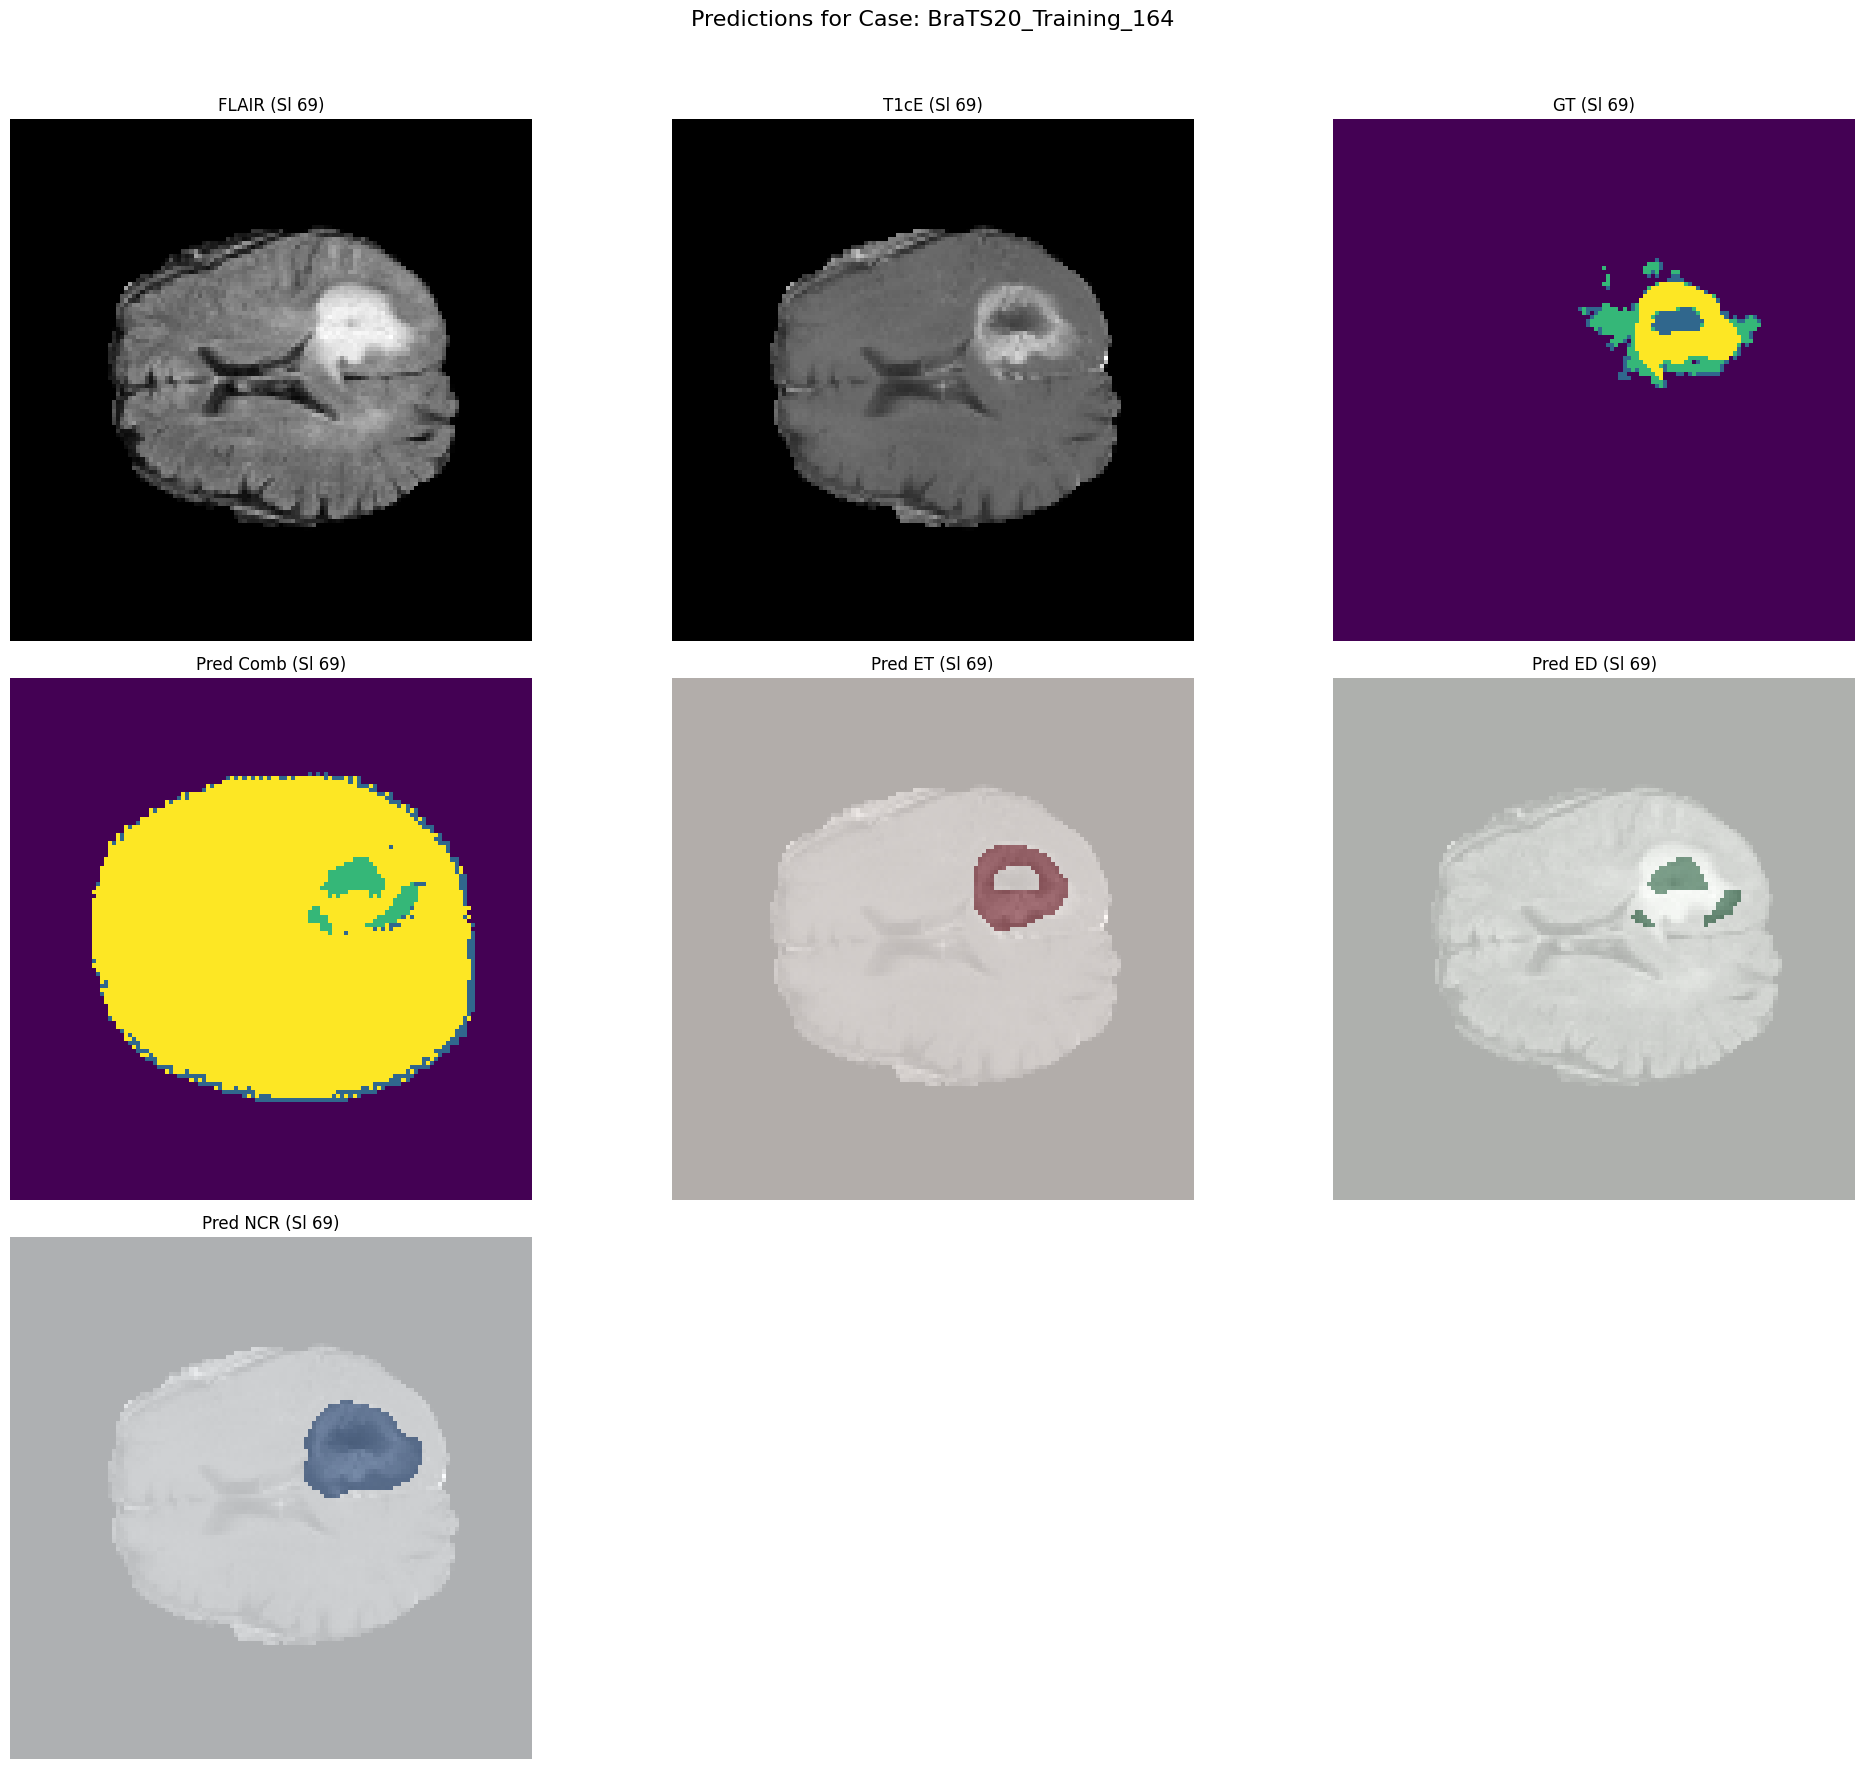


Evaluating Enhanced MM-UNet model on the test set...
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 817ms/step - combined_seg_accuracy: 0.7554 - combined_seg_dice_coef_combined_bg: 0.8612 - combined_seg_dice_coef_combined_ed: 0.3385 - combined_seg_dice_coef_combined_et: 0.0248 - combined_seg_dice_coef_combined_ncr: 0.0183 - combined_seg_iou_combined: 0.3750 - combined_seg_loss: 0.6893 - combined_seg_mean_dice_coef_per_class: 0.3107 - ed_binary_accuracy: 0.9932 - ed_binary_dice_coefficient: 0.3489 - ed_loss: 0.6511 - ed_precision_metric: 0.4830 - ed_sensitivity_metric: 0.3929 - et_binary_accuracy: 0.9978 - et_binary_dice_coefficient: 0.2248 - et_loss: 0.7752 - et_precision_metric: 0.4754 - et_sensitivity_metric: 0.2944 - loss: 1.8396 - ncr_binary_accuracy: 0.9879 - ncr_binary_dice_coefficient: 0.1256 - ncr_loss: 0.8744 - ncr_precision_metric: 0.2079 - ncr_sensitivity_metric: 0.4936
loss: 1.8778
compile_metrics: 0.6928
combined_seg_loss: 0.8328
et_loss: 0.655
ed_loss: 0.8821
ncr_loss: 0.7545


In [29]:
if train_ids: _dummy_dg_for_pred = DataGenerator(list_IDs=[], augment=False)
else: _dummy_dg_for_pred = DataGenerator(list_IDs=[], augment=False); print("Warning: train_ids empty, dummy DG for pred.")

def load_and_preprocess_single_volume_for_prediction(nii_path, target_dim=(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH)):
    try: vol_raw = nib.load(nii_path).get_fdata().astype(np.float32)
    except FileNotFoundError: print(f"File not found: {nii_path}"); return np.zeros(target_dim)
    except Exception as e: print(f"Error loading {nii_path}: {e}"); return np.zeros(target_dim)
    vol_z = _dummy_dg_for_pred._process_volume_z_dim(vol_raw, target_dim[2])
    vol_norm = _dummy_dg_for_pred._normalize_volume(vol_z)
    vol_patch = np.zeros(target_dim)
    for s_idx in range(target_dim[2]): vol_patch[...,s_idx] = cv2.resize(vol_norm[...,s_idx], (target_dim[1],target_dim[0]), cv2.INTER_LINEAR)
    return vol_patch

def predict_for_case(case_id, model_to_use, base_dataset_path=TRAIN_DATASET_PATH):
    case_path = os.path.join(base_dataset_path, case_id)
    flair_p_base = os.path.join(case_path, f'{case_id}_flair')
    t1ce_p_base = os.path.join(case_path, f'{case_id}_t1ce')
    flair_p = f"{flair_p_base}.nii" if os.path.exists(f"{flair_p_base}.nii") else f"{flair_p_base}.nii.gz"
    t1ce_p = f"{t1ce_p_base}.nii" if os.path.exists(f"{t1ce_p_base}.nii") else f"{t1ce_p_base}.nii.gz"

    flair_vol = load_and_preprocess_single_volume_for_prediction(flair_p)
    t1ce_vol = load_and_preprocess_single_volume_for_prediction(t1ce_p)
    X_pred = np.expand_dims(np.stack([flair_vol, t1ce_vol], axis=-1), axis=0)
    return model_to_use.predict(X_pred, verbose=0), X_pred

def display_predictions_for_case(case_id, model_to_use, slice_idx_in_patch=IMG_DEPTH//2):
    preds_dict, X_input_b = predict_for_case(case_id, model_to_use)
    if X_input_b is None or X_input_b.size == 0 : print(f"Could not get input for {case_id}"); return
    X_input = X_input_b[0]

    seg_p_base = os.path.join(TRAIN_DATASET_PATH, case_id, f'{case_id}_seg')
    seg_p = f"{seg_p_base}.nii" if os.path.exists(f"{seg_p_base}.nii") else f"{seg_p_base}.nii.gz"
    try: gt_raw = nib.load(seg_p).get_fdata().astype(np.uint8)
    except: gt_raw = np.zeros((IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH))
    gt_z = _dummy_dg_for_pred._process_volume_z_dim(gt_raw, IMG_DEPTH)
    gt_patch = np.zeros((IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH), dtype=np.uint8)
    for s_idx in range(IMG_DEPTH): gt_patch[...,s_idx] = cv2.resize(gt_z[...,s_idx], (IMG_WIDTH,IMG_HEIGHT), cv2.INTER_NEAREST)
    gt_patch[gt_patch==4]=3

    pred_comb_labels = np.argmax(preds_dict['combined_seg'][0], axis=-1)
    pred_et = (preds_dict['et'][0,...,0] > 0.5).astype(np.uint8)
    pred_ed = (preds_dict['ed'][0,...,0] > 0.5).astype(np.uint8)
    pred_ncr = (preds_dict['ncr'][0,...,0] > 0.5).astype(np.uint8)

    plt.figure(figsize=(20,18))
    titles = [f'FLAIR (Sl {slice_idx_in_patch})', f'T1cE (Sl {slice_idx_in_patch})', f'GT (Sl {slice_idx_in_patch})',
              f'Pred Comb (Sl {slice_idx_in_patch})', f'Pred ET (Sl {slice_idx_in_patch})', f'Pred ED (Sl {slice_idx_in_patch})', f'Pred NCR (Sl {slice_idx_in_patch})']
    imgs = [X_input[...,slice_idx_in_patch,0], X_input[...,slice_idx_in_patch,1], gt_patch[...,slice_idx_in_patch],
            pred_comb_labels[...,slice_idx_in_patch], pred_et[...,slice_idx_in_patch], pred_ed[...,slice_idx_in_patch], pred_ncr[...,slice_idx_in_patch]]
    cmaps = ['gray','gray',None,None,'Reds','Greens','Blues']
    for i, (img,title,cmap_val) in enumerate(zip(imgs,titles,cmaps)): # Corrected cmap variable name
        plt.subplot(3,3,i+1);
        if i>=4: base_idx = 1 if ('ET' in title or 'NCR' in title) else 0; plt.imshow(X_input[...,slice_idx_in_patch,base_idx], cmap='gray', alpha=0.6); plt.imshow(img, cmap=cmap_val, alpha=0.5)
        else: plt.imshow(img, cmap=cmap_val)
        plt.title(title); plt.axis('off')
    plt.suptitle(f"Predictions for Case: {case_id}", fontsize=16); plt.tight_layout(rect=[0,0,1,0.96]); plt.show()

if test_ids and loaded_model:
    for i in range(min(2, len(test_ids))): # Show for 2 test cases
        display_predictions_for_case(test_ids[i], loaded_model, slice_idx_in_patch=IMG_DEPTH//2 + 5)
else: print("Skipping prediction display as test_ids or loaded_model is not available.")

if test_generator and loaded_model:
    print("\nEvaluating Enhanced MM-UNet model on the test set...")
    eval_cb = [cb for cb in callbacks_enhanced if not isinstance(cb, (ModelCheckpoint, EarlyStopping))]
    results = loaded_model.evaluate(test_generator, callbacks=eval_cb, verbose=1)
    for name, value in zip(loaded_model.metrics_names, results): print(f"{name}: {round(value,4)}")
else: print("Skipping evaluation as test_generator or loaded_model is not available.")

In [30]:
'''# Show predictions for a few test cases
if test_ids and 'loaded_model' in globals():
    num_preds_to_show = min(3, len(test_ids))
    for i in range(num_preds_to_show):
        case_to_predict = test_ids[i]
        print(f"\nDisplaying predictions for test case: {case_to_predict}")
        display_predictions_for_case(case_to_predict, loaded_model, slice_idx_in_patch=IMG_DEPTH // 2 + 5) # Show a slightly off-center slice
        display_predictions_for_case(case_to_predict, loaded_model, slice_idx_in_patch=IMG_DEPTH // 3)
else:
    print("Test IDs or loaded_model not available. Skipping prediction display.")'''

'# Show predictions for a few test cases\nif test_ids and \'loaded_model\' in globals():\n    num_preds_to_show = min(3, len(test_ids))\n    for i in range(num_preds_to_show):\n        case_to_predict = test_ids[i]\n        print(f"\nDisplaying predictions for test case: {case_to_predict}")\n        display_predictions_for_case(case_to_predict, loaded_model, slice_idx_in_patch=IMG_DEPTH // 2 + 5) # Show a slightly off-center slice\n        display_predictions_for_case(case_to_predict, loaded_model, slice_idx_in_patch=IMG_DEPTH // 3)\nelse:\n    print("Test IDs or loaded_model not available. Skipping prediction display.")'

evaluation

# Filter Visualization

This section adapts the filter visualization technique to our 3D Multi-Modal U-Net.
It helps us understand what patterns individual filters in the convolutional layers
have learned to detect. We achieve this by generating an input image that maximizes
the activation of a specific filter.

In [32]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

model_to_visualize = None
if 'loaded_model' in globals() and loaded_model is not None:
    model_to_visualize = loaded_model
    print(f"Visualizing filters of: 'loaded_model' (hopefully trained)")
elif 'enhanced_mm_unet_model' in globals() and enhanced_mm_unet_model is not None:
    model_to_visualize = enhanced_mm_unet_model # Fallback to model at end of training
    print(f"Visualizing filters of: 'enhanced_mm_unet_model' (end of training instance)")
else:
    print("Warning: No suitable model found ('loaded_model' or 'enhanced_mm_unet_model').")
    print("Building a new UNTRAINED model instance for visualization demo.")
    # Ensure input_shape_mm is defined
    if 'input_shape_mm' not in globals():
        input_shape_mm = (IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, N_MODALITIES) # Define if not present
    model_to_visualize = build_enhanced_mm_unet(input_shape=input_shape_mm, dropout_rate=0.3)


def create_3d_input_image_for_vis(height, width, depth, n_modalities):
  """Creates a random 3D multi-modal input image."""
  img = tf.random.uniform((height, width, depth, n_modalities), minval=0.4, maxval=0.6, dtype=tf.float32)
  return img

def normalize_for_plotting(image_tensor):
    """Normalizes a tensor to 0-1 range for plotting."""
    min_val = tf.reduce_min(image_tensor)
    max_val = tf.reduce_max(image_tensor)
    if max_val == min_val: return tf.zeros_like(image_tensor)
    return (image_tensor - min_val) / (max_val - min_val)

def plot_3d_optimized_image_slices(image_3d_multimodal, title='Optimized 3D Input', slice_idx_depth=None):
  """Plots central slices of a 3D multi-modal image."""
  height, width, depth, n_modalities = image_3d_multimodal.shape
  if slice_idx_depth is None: slice_idx_depth = depth // 2
  if n_modalities < 1: return

  plt.figure(figsize=(6 * n_modalities, 6))
  for modality_idx in range(n_modalities):
    plt.subplot(1, n_modalities, modality_idx + 1)
    img_slice = image_3d_multimodal[:, :, slice_idx_depth, modality_idx]
    img_slice_np = img_slice.numpy() if isinstance(img_slice, tf.Tensor) else img_slice
    img_slice_normalized = normalize_for_plotting(img_slice_np)

    modality_name = "FLAIR-like" if modality_idx == 0 else "T1ce-like"
    plt.imshow(img_slice_normalized, cmap='viridis')
    plt.xticks([]); plt.yticks([])
    plt.title(f"{title}\n{modality_name} (Depth Slice: {slice_idx_depth})")
  plt.tight_layout(); plt.show()

def get_submodel_from_main_model(main_model, layer_name):
  try:
    target_layer = main_model.get_layer(layer_name)
    return tf.keras.models.Model(inputs=main_model.input, outputs=target_layer.output)
  except ValueError as e:
    print(f"Error creating submodel for layer '{layer_name}': {e}.")
    # print("Available layer names:"); [print(f"{l_idx}: {l.name} (Type: {type(l).__name__})") for l_idx,l in enumerate(main_model.layers)]
    return None

@tf.function
def gradient_ascent_step_3d(image_var, submodel, filter_index, learning_rate_vis):
    with tf.GradientTape() as tape:
        tape.watch(image_var)
        out_all_filters = submodel(tf.expand_dims(image_var, axis=0))
        out_target_filter_spatial = out_all_filters[0, ..., filter_index]
        loss = tf.math.reduce_mean(out_target_filter_spatial)

    grads = tape.gradient(loss, image_var)
    if grads is None: return loss, True
    grads = tf.math.l2_normalize(grads)
    image_var.assign_add(grads * learning_rate_vis)
    return loss, False

def visualize_filter_3d_from_model(main_model, layer_name_to_vis, filter_idx_to_vis=None, iters_vis=75, learning_rate_viz=1.0):
  if main_model is None: print("Model for visualization is None."); return

  submodel = get_submodel_from_main_model(main_model, layer_name_to_vis)
  if submodel is None: return

  num_output_channels = submodel.output.shape[-1]

  if filter_idx_to_vis is None:
      filter_idx_to_vis = random.randint(0, num_output_channels - 1)
  elif not isinstance(filter_idx_to_vis, int) or not (0 <= filter_idx_to_vis < num_output_channels):
      print(f"Invalid filter_index '{filter_idx_to_vis}'. Must be int from 0 to {num_output_channels-1}. Visualizing random filter.")
      filter_idx_to_vis = random.randint(0, num_output_channels - 1)

  print(f"Visualizing filter {filter_idx_to_vis} of layer '{layer_name_to_vis}' ({num_output_channels} filters total)")

  h, w, d, m = main_model.input.shape[1:]
  image_3d_var = tf.Variable(create_3d_input_image_for_vis(h, w, d, m))

  verbose_step = max(1, iters_vis // 10)
  for i in range(iters_vis):
    loss, grads_are_none = gradient_ascent_step_3d(image_3d_var, submodel, filter_idx_to_vis, learning_rate_viz)
    if grads_are_none:
        print(f"Iter {i+1}: Grads None. Stopping."); break
    if (i + 1) % verbose_step == 0:
        print(f'Iter: {i+1}, Loss (Mean Activation): {loss.numpy():.4f}')

  plot_3d_optimized_image_slices(image_3d_var.numpy(), f'{layer_name_to_vis}, Filter {filter_idx_to_vis}')

Visualizing filters of: 'loaded_model' (hopefully trained)


In [ ]:
'''@tf.function # For performance
def gradient_ascent_step_3d(image_var, submodel, filter_index, learning_rate_vis):
    with tf.GradientTape() as tape:
        tape.watch(image_var)
        # submodel(input) returns the output of the specified layer
        # Output shape is (batch, H_out, W_out, D_out, num_output_channels/filters)
        out_all_filters = submodel(tf.expand_dims(image_var, axis=0)) # Add batch dimension

        # Ensure target_filter_output is from the spatial center to reduce edge effects, if desired
        # Or just take the mean over the whole spatial volume of the filter's activation
        out_target_filter_spatial = out_all_filters[0, ..., filter_index] # Shape (H_out, W_out, D_out)
        loss = tf.math.reduce_mean(out_target_filter_spatial) # Mean activation of the target filter

    grads = tape.gradient(loss, image_var)
    if grads is None:
        # print("Gradients are None. This might happen if the path to loss is broken or for non-trainable Variables not watched.")
        return loss, True # Indicate grads are None

    grads = tf.math.l2_normalize(grads) # Normalize gradients
    image_var.assign_add(grads * learning_rate_vis) # Gradient ascent

    # Optional: Add small L2 decay to the image to prevent very high frequencies
    # image_var.assign(image_var * (1 - 0.005))
    # Optional: Clip image values if they tend to explode (depends on initialization)
    # image_var.assign(tf.clip_by_value(image_var, 0.0, 1.0)) # if initialized 0-1
    return loss, False


def visualize_filter_3d_from_model(main_model, layer_name, filter_index=None, iters=75, learning_rate_vis=1.0):
  if main_model is None: print("Model for visualization is None. Exiting."); return

  submodel = get_submodel_from_main_model(main_model, layer_name)
  if submodel is None: return # Error message printed in get_submodel

  # The number of output channels/filters of the target layer
  num_output_channels = submodel.output.shape[-1]

  if filter_index is None: filter_index = random.randint(0, num_output_channels - 1)

  if not (0 <= filter_index < num_output_channels):
    print(f"Error: filter_index {filter_index} is out of bounds for layer {layer_name} which has {num_output_channels} filters."); return

  print(f"Visualizing filter {filter_index} of layer '{layer_name}' (Layer has {num_output_channels} filters total)")

  # Get input shape from the main model
  h, w, d, m = main_model.input.shape[1:] # (H, W, D, N_MODALITIES)
  image_3d_var = tf.Variable(create_3d_input_image_for_vis(h, w, d, m)) # Create as tf.Variable

  verbose_step = max(1, iters // 10)
  for i in range(iters):
    loss, grads_are_none = gradient_ascent_step_3d(image_3d_var, submodel, filter_index, learning_rate_vis)
    if grads_are_none:
        print(f"Iteration {i+1}: Gradients were None. This can happen if the filter index is out of range for the specific output tensor slice, or if the layer has no trainable weights influencing this specific output. Stopping visualization for this filter.");
        break
    if (i + 1) % verbose_step == 0:
        print(f'Iteration: {i+1}, Loss (Mean Activation): {loss.numpy():.4f}')

  plot_3d_optimized_image_slices(image_3d_var.numpy(), f'{layer_name}, Filter {filter_index}')


if model_to_visualize is not None:
    print("\n--- Listing Convolutional Layers for Visualization ---")
    conv_layer_names_for_vis = []
    for layer_idx, layer in enumerate(model_to_visualize.layers):
        # We are interested in Conv3D layers, not Conv3DTranspose for typical filter viz
        if isinstance(layer, tf.keras.layers.Conv3D):
            conv_layer_names_for_vis.append(layer.name)
            print(f"Index: {layer_idx}, Name: {layer.name} (Type: {type(layer).__name__}), Output shape: {layer.output_shape}")

    if conv_layer_names_for_vis:
        print("\n--- Attempting Filter Visualizations ---")

        # Candidate layer names based on the build_enhanced_mm_unet function's naming
        # Check your model summary for exact names if these don't work.

        # Example 1: An early layer in the FLAIR encoder path
        target_layer_name_1 = "flair_enc_1_resconv_conv1" # First Conv3D in the first residual block of flair encoder
        if target_layer_name_1 in conv_layer_names_for_vis:
            print(f"\nVisualizing for: {target_layer_name_1}")
            visualize_filter_3d_from_model(model_to_visualize, target_layer_name_1, filter_index=0, iters=50, learning_rate_vis=2.0)
            num_filters_layer1 = model_to_visualize.get_layer(target_layer_name_1).output.shape[-1]
            if num_filters_layer1 > 1: # Visualize another filter if available
                 visualize_filter_3d_from_model(model_to_visualize, target_layer_name_1, filter_index=min(1, num_filters_layer1-1), iters=50, learning_rate_vis=2.0)
        else:
            print(f"Layer '{target_layer_name_1}' not found. Trying the very first Conv3D layer: '{conv_layer_names_for_vis[0]}'")
            visualize_filter_3d_from_model(model_to_visualize, conv_layer_names_for_vis[0], filter_index=0, iters=50, learning_rate_vis=2.0)

        # Example 2: A layer in the bottleneck
        target_layer_name_2 = "bottleneck_proc_resconv_conv1" # First Conv3D in the final bottleneck processing block
        if target_layer_name_2 in conv_layer_names_for_vis:
            print(f"\nVisualizing for: {target_layer_name_2}")
            num_filters_bn = model_to_visualize.get_layer(target_layer_name_2).output.shape[-1]
            visualize_filter_3d_from_model(model_to_visualize, target_layer_name_2, filter_index=min(5, num_filters_bn-1), iters=60, learning_rate_vis=1.5)
        else: # Fallback to a generally deeper layer if specific name not found
            if len(conv_layer_names_for_vis) > 10: # Heuristic for a deeper layer
                deeper_layer_name = conv_layer_names_for_vis[10] # Example
                print(f"Layer '{target_layer_name_2}' not found. Trying a deeper layer: '{deeper_layer_name}'")
                num_filters_deeper = model_to_visualize.get_layer(deeper_layer_name).output.shape[-1]
                visualize_filter_3d_from_model(model_to_visualize, deeper_layer_name, filter_index=min(0, num_filters_deeper-1), iters=60, learning_rate_vis=1.5)


        # Example 3: A layer in the decoder (after an attention gate)
        # Name example: "dec_1_resconv_conv1" (first resconv block in the first decoder stage)
        target_layer_name_3 = "dec_4_resconv_conv1" # Last decoder stage, first conv in its resblock
                                                     # (dec_4 because filters = [16,32,64,128,256], so 4 encoder blocks before bottleneck, 4 decoder blocks)
        if target_layer_name_3 in conv_layer_names_for_vis:
            print(f"\nVisualizing for: {target_layer_name_3}")
            num_filters_dec = model_to_visualize.get_layer(target_layer_name_3).output.shape[-1]
            visualize_filter_3d_from_model(model_to_visualize, target_layer_name_3, filter_index=min(0, num_filters_dec-1), iters=50, learning_rate_vis=1.0)
        else:
            if len(conv_layer_names_for_vis) > 15: # Heuristic
                 decoder_layer_name = conv_layer_names_for_vis[15]
                 print(f"Layer '{target_layer_name_3}' not found. Trying a decoder layer: '{decoder_layer_name}'")
                 num_filters_dec_fallback = model_to_visualize.get_layer(decoder_layer_name).output.shape[-1]
                 visualize_filter_3d_from_model(model_to_visualize, decoder_layer_name, filter_index=min(0, num_filters_dec_fallback-1), iters=50, learning_rate_vis=1.0)


    else:
        print("No Conv3D layers (excluding Transpose) found in the model to visualize.")
else:
    print("model_to_visualize is not set. Cannot run filter visualization.")'''

In [38]:
# --- Interactive Filter Visualization Setup ---
if model_to_visualize is not None:
    print("\n--- Interactive Filter Visualization ---")

    conv_layer_names_for_vis = []
    for layer in model_to_visualize.layers:
        if isinstance(layer, tf.keras.layers.Conv3D): # Only Conv3D, not Conv3DTranspose
            conv_layer_names_for_vis.append(layer.name)

    if not conv_layer_names_for_vis:
        print("No Conv3D layers found in the model to visualize.")
    else:
        # Create dropdown for layer selection
        layer_dropdown = widgets.Dropdown(
            options=conv_layer_names_for_vis,
            value=conv_layer_names_for_vis[0], # Default to the first conv layer
            description='Layer:',
            disabled=False,
        )

        # Text input for filter index
        filter_index_input = widgets.IntText(
            value=0, # Default filter index
            description='Filter Index:',
            disabled=False
        )

        # Text input for iterations
        iterations_input = widgets.IntText(
            value=50, # Default iterations
            description='Iterations:',
            disabled=False
        )

        # Text input for learning rate
        lr_input = widgets.FloatText(
            value=1.5, # Default learning rate
            description='Learn Rate:',
            step=0.1,
            disabled=False
        )

        # Button to trigger visualization
        visualize_button = widgets.Button(description="Visualize Filter")

        # Output widget to display plots and text below the controls
        output_area = widgets.Output()

        def on_visualize_button_clicked(b):
            with output_area: # Capture output within this widget
                clear_output(wait=True) # Clear previous output in this area
                selected_layer = layer_dropdown.value
                selected_filter_idx = filter_index_input.value
                selected_iters = iterations_input.value
                selected_lr = lr_input.value

                print(f"Requesting visualization for: Layer='{selected_layer}', Filter Index={selected_filter_idx}, Iters={selected_iters}, LR={selected_lr}")

                # Validate filter index against the selected layer's capabilities
                try:
                    layer_obj = model_to_visualize.get_layer(selected_layer)
                    max_filter_idx = layer_obj.output.shape[-1] - 1
                    if not (0 <= selected_filter_idx <= max_filter_idx):
                        print(f"Warning: Filter index {selected_filter_idx} is out of range for layer '{selected_layer}' (0-{max_filter_idx}).")
                        print(f"Please choose a valid filter index for this layer.")
                        return # Stop if filter index is invalid
                except Exception as e:
                    print(f"Could not validate filter index: {e}")
                    # Continue, visualize_filter_3d_from_model might handle it or error out

                visualize_filter_3d_from_model(
                    model_to_visualize,
                    selected_layer,
                    filter_idx_to_vis=selected_filter_idx,
                    iters_vis=selected_iters,
                    learning_rate_viz=selected_lr
                )

        visualize_button.on_click(on_visualize_button_clicked)

        # Display the interactive elements
        print("Select a Conv3D layer and filter index to visualize:")
        display(widgets.VBox([layer_dropdown, filter_index_input, iterations_input, lr_input, visualize_button, output_area]))

        # You can also trigger an initial visualization if desired, e.g., for the default selection:
        # on_visualize_button_clicked(None)
        # But it's better to let the user click the button.

else:
    print("model_to_visualize is not set. Cannot run interactive filter visualization.")


--- Interactive Filter Visualization ---
Select a Conv3D layer and filter index to visualize:
